In [1]:
!pip install datasets
!pip install wikidata
!pip install SPARQLWrapper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

## Import Libraries

In [2]:
# Extract features
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from huggingface_hub import notebook_login
import requests
from wikidata.client import Client
from collections import Counter
import re
from tqdm import tqdm
from datetime import datetime, timedelta
import urllib
import time

# Graph part and query
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import requests
from SPARQLWrapper import SPARQLWrapper, JSON
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Train NO LLM model
import sklearn as sk
import pandas as pd
import matplotlib.pyplot as plt
import time
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Mounted at /content/drive


# Path of CSV

In [51]:
train_dataset_path = '/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/train_dataset.csv'
augmented_train_dataset_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_train_dataset.csv"
train_descriptions_path  = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/train_set_descriptions.csv"
train_wiki_file_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/wikidata_wikipedia_views_stats.csv"


original_dev_dataset_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/original_dev_dataset.csv"
augmented_dev_dataset_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_dev_dataset.csv"
dev_description_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/dev_descriptions.csv"
dev_wiki_file_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/dev_wiki_file_path.csv"


original_test_dataset_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/test_unlabeled.csv"
augmented_test_dataset_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/augmented_test_dataset.csv"
test_description_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/test_descriptions.csv"
test_wiki_file_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/test_wiki_file_path.csv"

# PATH for NO LLM model
best_model_svm_path = '/content/drive/MyDrive/the_tokenizers_shared_folder/trained_model/best_svm_model.pkl'
best_model_rf_path = '/content/drive/MyDrive/the_tokenizers_shared_folder/trained_model/best_rf_model.pkl'
best_model_xgb_path = '/content/drive/MyDrive/the_tokenizers_shared_folder/trained_model/best_xgb_model.pkl'

## Dataset

In [ ]:
notebook_login()
# Code for install Huggin Face
dat = load_dataset('sapienzanlp/nlp2025_hw1_cultural_dataset')

In [ ]:
df_train = dat['train'].to_pandas()
df_valid = dat['validation'].to_pandas()
labels = sorted(list(df_train["label"].unique()))

df_train.to_csv(train_dataset_path, index=False)
df_valid.to_csv(original_dev_dataset_path, index=False)

# Exploration of dataset

In [ ]:
# Takes only colums 'label'
counts = df_train["label"].value_counts()

# Counts num elements for each label
cultural_rep = counts.get("cultural representative", 0)
cultural_exc = counts.get("cultural exclusive", 0)
cultural_agn = counts.get("cultural agnostic", 0)

print(f"Cultural representative: {cultural_rep}")
print(f"Cultural exclusive: {cultural_exc}")
print(f"Cultural agnostic: {cultural_agn}")

Cultural representative: 1688
Cultural exclusive: 2691
Cultural agnostic: 1872


In [ ]:
df_train.head()

,item,name,description,type,category,subcategory,label
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251 entries, 0 to 6250
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item         6251 non-null   object
 1   name         6251 non-null   object
 2   description  6251 non-null   object
 3   type         6251 non-null   object
 4   category     6251 non-null   object
 5   subcategory  6251 non-null   object
 6   label        6251 non-null   object
dtypes: object(7)
memory usage: 342.0+ KB


In [ ]:
df_train.describe()

,item,name,description,type,category,subcategory,label
count,6251,6251,6251,6251,6251,6251,6251
unique,6251,6245,5672,2,19,108,3
top,http://www.wikidata.org/entity/Q129298,central government,film genre,entity,politics,politician,cultural exclusive
freq,1,2,32,3924,532,99,2691


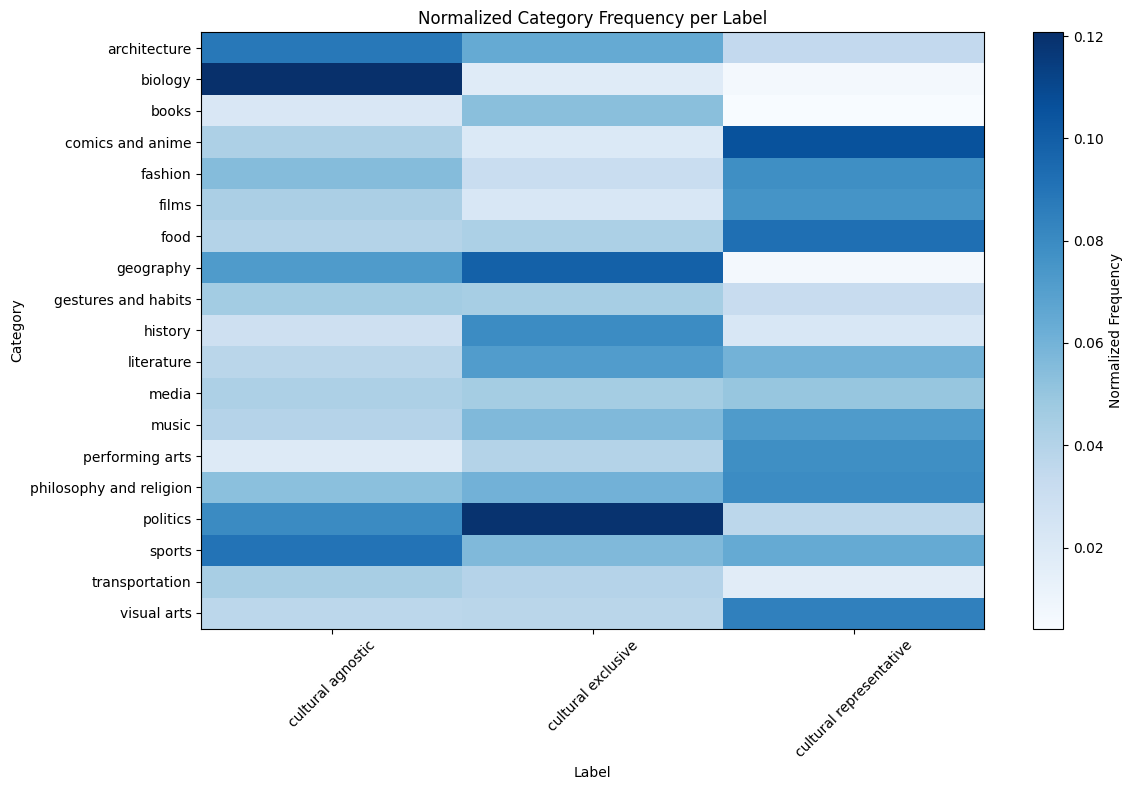

In [ ]:
# Extract list of categories from comma-separated strings
# - splits the string by commas -> x.split(',')
# - for each substring `cat`:
#     - cat.strip() -> removes leading/trailing whitespace
#     - cat.strip().lower() -> converts it to lowercase
df_train['category_list'] = df_train['category'].fillna('').apply(
    lambda x: [cat.strip().lower() for cat in x.split(',') if cat.strip()]
)

# Build a DataFrame for category-label pairs
rows = []
for _, row in df_train.iterrows():
    for cat in row['category_list']:
        rows.append({'category': cat, 'label': row['label']})

cat_label_df = pd.DataFrame(rows)

# Count category occurrences per label (raw counts)
category_counts = pd.crosstab(cat_label_df['category'], cat_label_df['label'])

# Normalize the counts per label (column-wise)
category_freq = category_counts.div(category_counts.sum(axis=0), axis=1)

plt.figure(figsize=(12, 8))
plt.imshow(category_freq, cmap='Blues', aspect='auto')
plt.colorbar(label='Normalized Frequency')
plt.xticks(ticks=range(len(category_freq.columns)), labels=category_freq.columns, rotation=45)
plt.yticks(ticks=range(len(category_freq.index)), labels=category_freq.index)
plt.title('Normalized Category Frequency per Label')
plt.xlabel('Label')
plt.ylabel('Category')
plt.tight_layout()
plt.show()

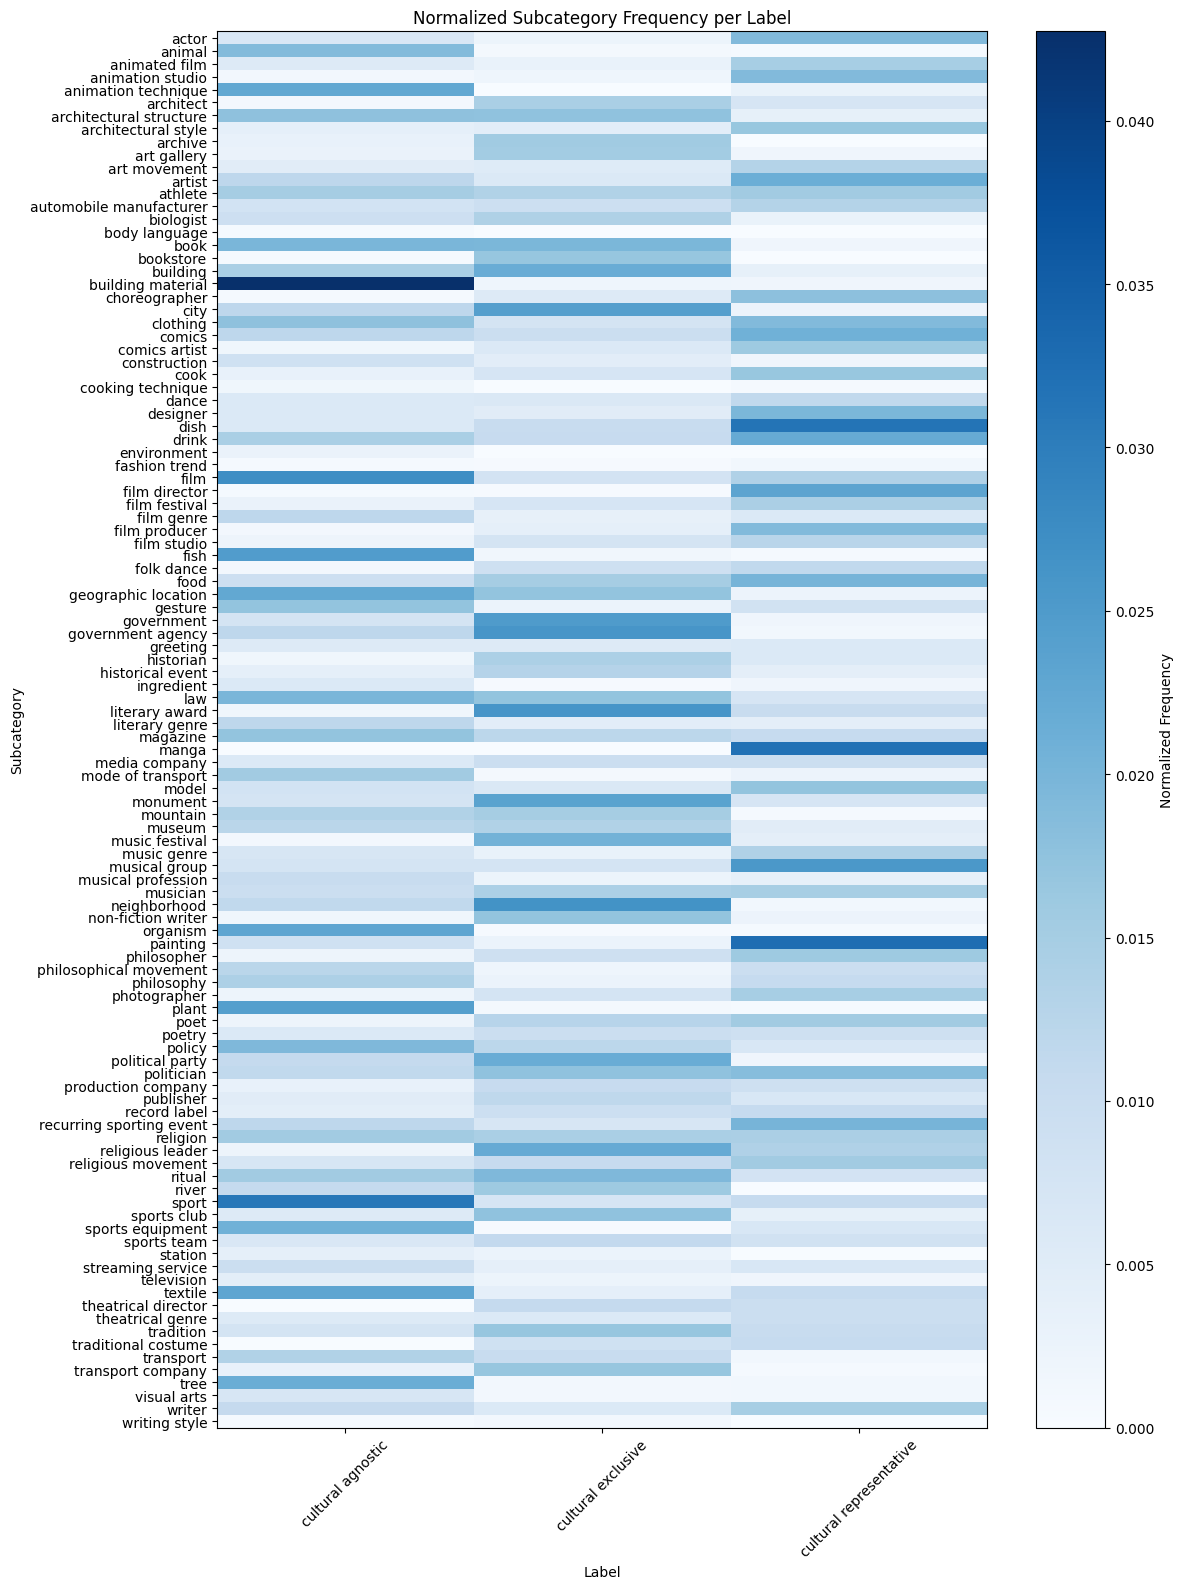

In [ ]:
# Extract list of subcategories from comma-separated strings
# - splits the string by commas -> x.split(',')
# - for each substring `cat`:
#     - cat.strip() -> removes leading/trailing whitespace
#     - cat.strip().lower() -> converts it to lowercase
df_train['subcategory_list'] = df_train['subcategory'].fillna('').apply(
    lambda x: [cat.strip().lower() for cat in x.split(',') if cat.strip()]
)

# Build a long-form DataFrame for subcategory-label pairs
rows = []
for _, row in df_train.iterrows():
    for cat in row['subcategory_list']:
        rows.append({'subcategory': cat, 'label': row['label']})

cat_label_df = pd.DataFrame(rows)

# Count subcategory occurrences per label
subcategory_counts = pd.crosstab(cat_label_df['subcategory'], cat_label_df['label'])

# Normalize the counts per label (column-wise normalization)
subcategory_freq = subcategory_counts.div(subcategory_counts.sum(axis=0), axis=1)

# Plot the normalized heatmap
plt.figure(figsize=(12, 16))
plt.imshow(subcategory_freq, cmap='Blues', aspect='auto')
plt.colorbar(label='Normalized Frequency')
plt.xticks(ticks=range(len(subcategory_freq.columns)), labels=subcategory_freq.columns, rotation=45)
plt.yticks(ticks=range(len(subcategory_freq.index)), labels=subcategory_freq.index)
plt.title('Normalized Subcategory Frequency per Label')
plt.xlabel('Label')
plt.ylabel('Subcategory')
plt.tight_layout()
plt.show()


# Featuring Extraction

The following code is used for see if there are words that are more revelant respect other

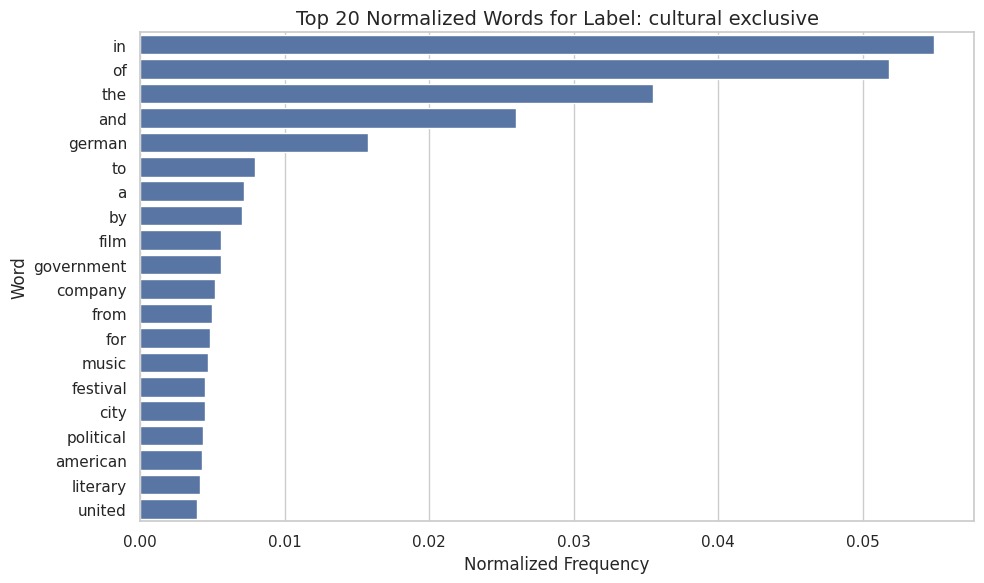

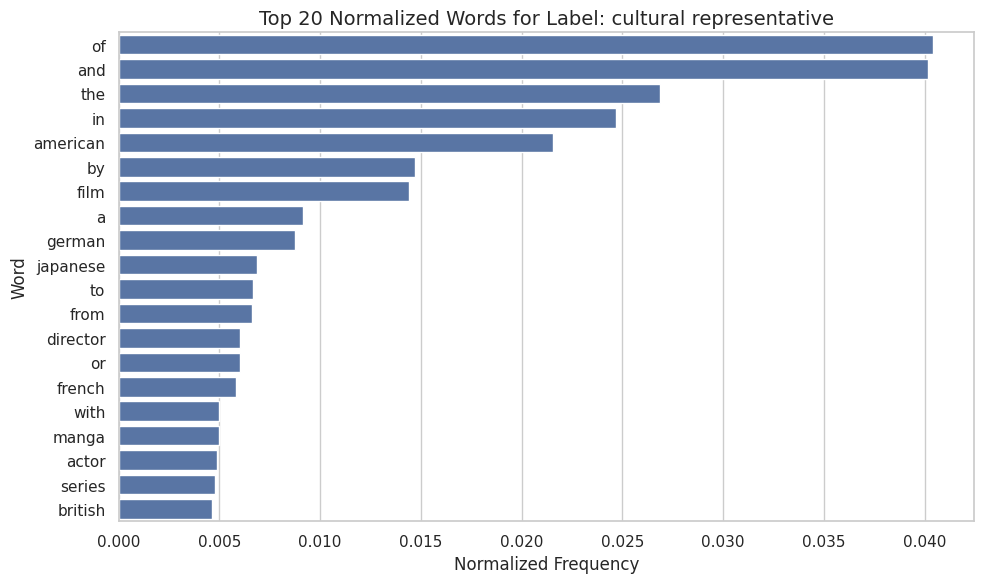

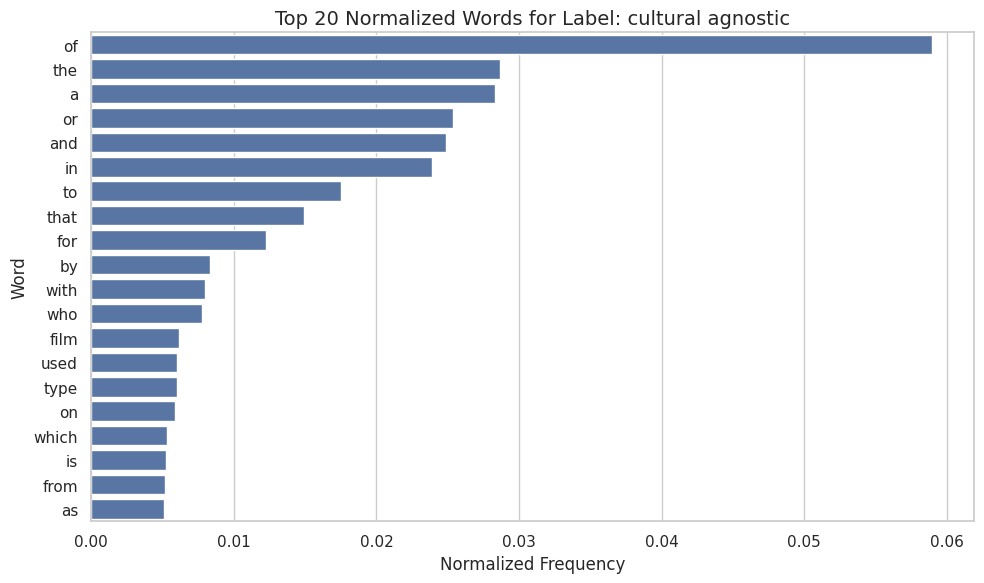

In [ ]:
# Function to clean and tokenize text using regex
def tokenize(text):
    """
    Converts text to lowercase and extracts word tokens using re.
    """
    words = re.findall(r'\b\w+\b', text.lower())
    return words

# Dictionary to store normalized word frequencies for each label
label_word_counts = {}

# Iterate over each unique label in the dataset
for label in df_train['label'].unique():
    subset = df_train[df_train['label'] == label]
    words = []

    for desc in subset['description'].dropna():
        words.extend(tokenize(desc))

    word_counter = Counter(words)
    total_words = sum(word_counter.values())

    # Normalize word frequencies
    if total_words > 0:
        normalized_counter = {word: count / total_words for word, count in word_counter.items()}
    else:
        normalized_counter = {}

    label_word_counts[label] = Counter(normalized_counter)

sns.set_theme(style="whitegrid")

# Plot the top 20 normalized words for each label
for label, counter in label_word_counts.items():
    top_words = counter.most_common(20)
    words, freqs = zip(*top_words)

    # Create a horizontal bar plot using Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(x=freqs, y=words)  # horizontal barplot
    plt.title(f"Top 20 Normalized Words for Label: {label}", fontsize=14)
    plt.xlabel("Normalized Frequency")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()

## Name Length and Num of Words

In [ ]:
def add_name_length(dataset):
    dataset["name_length"] = dataset["name"].apply(len)
    return dataset

def add_count_num_of_words(dataset):
    dataset["num_words"] = dataset["name"].apply(lambda x: len(str(x).split()))
    return dataset


## Description Length

In [ ]:
def add_description_length(dataset):
    dataset["description_length"] = dataset["description"].apply(len)
    return dataset

def count_words(text):
    return len(str(text).split())

def add_description_word_count(dataset):
    dataset["description_word_count"] = dataset["description"].apply(count_words)
    return dataset

## Num WikiPages for each Item
This code iterates over Wikidata entity URLs column and uses the Wikidata API to count how many Wikipedia language editions (e.g., English, French, German) are linked to each entity

In [ ]:
# Enables tqdm progress bar support for pandas .progress_apply() functions
tqdm.pandas()

# Extract the Wikidata entity ID from a full URL
def extract_entity_id(url):
    return url.strip().split("/")[-1]

def add_wikipages_language_info(dataset):
    client = Client()
    total_wiki_counts = []
    top_lang_wiki_counts = []
    wiki_languages = []

    # Top 10 Wikipedia language codes by usage (approximate)
    top_10_lang_codes = {"en", "es", "de", "fr", "ru", "it", "ja", "zh", "pt", "ar"}

    for wikidata_url in tqdm(dataset["item"], desc="Processing Wikidata entities"):
        try:
            # Extract the entity ID and fetch the item from Wikidata
            entity_id = extract_entity_id(wikidata_url)
            item = client.get(entity_id, load=True)
            sitelinks = item.data.get("sitelinks", {})
            # Extract valid language codes from sitelinks (ignore commons)
            langs = [
                site_key.replace("wiki", "")
                for site_key in sitelinks
                if site_key.endswith("wiki") and not site_key.startswith("commons")
            ]

            total_wiki_counts.append(len(langs))
            wiki_languages.append(", ".join(sorted(langs)))
            # Count how many of those languages are in the top 10
            top_lang_wiki_counts.append(sum(lang in top_10_lang_codes for lang in langs))

        except Exception as e:
            print(f"Errore con {wikidata_url}: {e}")
            total_wiki_counts.append(0)
            top_lang_wiki_counts.append(0)
            wiki_languages.append("")

    dataset["wiki_pages"] = total_wiki_counts
    dataset["wiki_langs"] = wiki_languages
    dataset["wiki_top10_langs_count"] = top_lang_wiki_counts

    return dataset

## Num of Alias
This code retrieves the number of aliases associated with each Wikidata entity.

In [ ]:
# Enables tqdm progress bar support for pandas .progress_apply() functions
tqdm.pandas()

def get_alias_count(wikidata_url):
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/75.0.3770.100 Safari/537.36'
        )
    }

    try:
        # Extract the entity ID from the full URL
        entity_id = wikidata_url.strip().split("/")[-1]
        # Build the Wikidata API URL to fetch entity data in JSON format
        url = f"https://www.wikidata.org/wiki/Special:EntityData/{entity_id}.json"
        # Send the HTTP GET request
        response = requests.get(url, headers=headers)
        response.raise_for_status()

        data = response.json()
        aliases = data['entities'][entity_id].get('aliases', {})

        # Count all alias entries across all languages
        alias_count = sum(len(v) for v in aliases.values())
        return alias_count
    except Exception as e:
        print(f"Error for {wikidata_url}: {e}")
        return 0

def add_alias_count_to_df(dataset):
    dataset['alias_count'] = dataset['item'].progress_apply(get_alias_count)
    dataset['alias_count'] = dataset['alias_count'].fillna(0)
    # Convert in int for Histogram
    dataset['alias_count'] = dataset['alias_count'].astype(int)
    return dataset


## Num of Images
This code calculates the number of image-related claims (properties with the commonsMedia datatype) for each Wikidata entity

In [ ]:
def get_num_images(q_number):
    # Build the Wikidata API URL for the given QID
    url = f"https://www.wikidata.org/wiki/Special:EntityData/{q_number}.json"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/75.0.3770.100 Safari/537.36'
        )
    }
    # Send the HTTP GET request
    response = requests.get(url, headers=headers)

    if response.status_code != 200:
        print(f"Errore per {q_number} - status: {response.status_code}")
        return 0

    data = response.json()
    entities = data.get("entities", {})
    entity_data = entities.get(q_number, {})
    claims = entity_data.get("claims", {})

    # List of Wikidata properties that typically contain image or media links
    media_props = [
        'P10',  # video
        'P14',  # sound
        'P18',  # image
        'P41',  # flag image
        'P94',  # coat of arms image
        'P109', # signature
        'P154', # logo image
        'P242', # locator map image
        'P2716' # collage image
    ]

    # Count how many media values are present for the given properties
    count = 0
    for prop in media_props:
        if prop in claims:
            count += len(claims[prop])
    return count


def add_num_images(dataset):
    # Create a new column in the dataset to store the number of images
    dataset['num_images'] = 0

    # Use tqdm to show progress while iterating over the dataframe
    for idx, row in tqdm(dataset.iterrows(), total=len(dataset)):
        item_uri = row['item']  # e.g. 'http://www.wikidata.org/entity/Q91'
        q_number = item_uri.split('/')[-1]  # Get 'Q91' from the URL
        dataset.loc[idx, 'num_images'] = get_num_images(q_number)

    dataset['num_images'] = pd.to_numeric(dataset['num_images'], errors='coerce' ).fillna(0).astype(int)
    return dataset

## Num External links
This script calculates how many external links are present on the English Wikipedia page associated with each Wikidata entity

In [ ]:
tqdm.pandas()

headers = {
    'User-Agent': (
        'Mozilla/5.0 (Windows NT 6.2; Win64; x64) '
        'AppleWebKit/537.36 (KHTML, like Gecko) '
        'Chrome/75.0.3770.100 Safari/537.36'
    )
}

def get_external_link_count(wikidata_url):
    try:
        # Extract ID
        entity_id = wikidata_url.strip().split("/")[-1]

        # Request entity data from the Wikidata API
        wikidata_api_url = f"https://www.wikidata.org/wiki/Special:EntityData/{entity_id}.json"
        # Send the HTTP GET request
        response = requests.get(wikidata_api_url, headers=headers)
        response.raise_for_status()
        data = response.json()

        # Try to get the English Wikipedia title linked to this Wikidata entity
        sitelinks = data['entities'][entity_id].get('sitelinks', {})
        enwiki = sitelinks.get('enwiki', {}).get('title', None)
        if not enwiki:
            return 0

        # Request external links from the English Wikipedia page
        wikipedia_api_url = "https://en.wikipedia.org/w/api.php"
        params = {
            "action": "parse",
            "page": enwiki,
            "prop": "externallinks",
            "format": "json"
        }

        # Send the HTTP GET request
        wiki_response = requests.get(wikipedia_api_url, params=params, headers=headers)
        wiki_response.raise_for_status()
        wiki_data = wiki_response.json()

        external_links = wiki_data.get("parse", {}).get("externallinks", [])
        return len(external_links)

    except Exception as e:
        print(f"Error for {wikidata_url}: {e}")
        return 0

def add_external_link_count(dataframe):
    dataframe['external_links_count'] = dataframe['item'].progress_apply(get_external_link_count)
    dataframe['external_links_count'] = pd.to_numeric(
    dataframe['external_links_count'], errors='coerce'
    ).fillna(0).astype(int)
    return  dataframe



## Num uppercase and lowercase letters


In [ ]:
def count_uppercase(text):
    return sum(1 for c in str(text) if c.isupper())

def add_uppercase_number(dataframe):
    dataframe["uppercase_count"] = dataframe["name"].apply(count_uppercase)
    dataframe["uppercase_count_ratio"] = dataframe["uppercase_count"] / dataframe["num_words"]
    return dataframe


## Wikipedia Text Extraction
This script extracts a brief textual description (up to the first 1000 characters) from the English Wikipedia page linked to each Wikidata entity in a dataset

In [ ]:
def extract_entity_id(url):
    match = re.search(r"Q\d+", url)
    return match.group(0) if match else None

headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 6.2; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/75.0.3770.100 Safari/537.36'
        )
    }

# Save the first 1000 characters from the English Wikipedia page of each Wikidata item
def save_first_1000_chars(dataset, output_file):
    texts = []
    client = Client()
    for i, wikidata_url in enumerate(dataset["item"], 1):
        print(f"[{i}] Processing:", wikidata_url)
        entity_id = extract_entity_id(wikidata_url)
        print("Entity ID:", entity_id)

        first_1000_chars = ""

        try:
            # Validate extracted ID
            if not entity_id:
                raise ValueError("Invalid entity ID extracted")

            # Load full entity data from Wikidata with GET request
            item = client.get(entity_id, load=True)
            sitelinks = item.data.get("sitelinks", {})
            enwiki = sitelinks.get("enwiki")

            if enwiki:
                # Get the English Wikipedia page title
                title = enwiki["title"]

                # Wikipedia API parameters to get plain text extract
                api_url = "https://en.wikipedia.org/w/api.php"
                params = {
                    "action": "query",
                    "prop": "extracts",
                    "explaintext": True,
                    "titles": title,
                    "format": "json",
                    "redirects": 1
                }

                # Send request with headers
                res = requests.get(api_url, params=params, headers=headers).json()
                page = next(iter(res["query"]["pages"].values()))
                text = page.get("extract", "")
                first_1000_chars = text[:1000]

            else:
                print("No English Wikipedia page found for this entity.")

        except Exception as e:
            print(f"Error processing entity '{entity_id}': {e}")

        # Append result for this entity
        texts.append({
            "item": wikidata_url,
            "text": first_1000_chars
        })

        # time.sleep(1.0)

    # Save results to CSV
    df_texts = pd.DataFrame(texts)
    if "label" in dataset.columns:
        df_texts["label"] = dataset["label"]
    df_texts.to_csv(output_file, index=False)
    print(f"\nFile saved to: '{output_file}'")



## Wikipedia View Analysis for Wikidata Items
This function enriches each Wikidata item with total Wikipedia pageviews over the past 90 days

In [ ]:
def dataset_with_wikipedia_views(df, wiki_file_path, days=90, max_retries=3):
    # Extract the Wikidata Q-ID
    df["wikidata_id"] = df["item"].str.extract(r"(Q\d+)")
    wikidata_ids = df["wikidata_id"].dropna().unique()
    print(f"Found {len(wikidata_ids)} unique Wikidata IDs")

    views_summary = []

    # Try to get the English Wikipedia title linked to this Wikidata entity
    def get_wikipedia_title(wid):
        try:
            url = f"https://www.wikidata.org/wiki/Special:EntityData/{wid}.json"
            headers = {'User-Agent': 'WikipediaViewsScript/1.0'}
            r = requests.get(url, headers=headers)
            if r.status_code == 200:
                entity = r.json()["entities"][wid]
                return entity["sitelinks"]["enwiki"]["title"] if "enwiki" in entity.get("sitelinks", {}) else None
        except Exception as e:
            print(f"Error fetching title for {wid}: {e}")
        return None

    def page_exists(title):
        try:
            encoded = urllib.parse.quote(title.replace(" ", "_"))
            url = f"https://en.wikipedia.org/w/api.php?action=query&titles={encoded}&format=json"
            headers = {'User-Agent': 'WikipediaViewsScript/1.0'}
            r = requests.get(url, headers=headers)
            return "-1" not in r.json()["query"]["pages"]
        except Exception as e:
            print(f"Error checking existence for {title}: {e}")
        return False

    # Filter out titles that contain characters
    def is_problematic(title):
        return any(c in title for c in ['¡', '+', '%', '&', '"', '#'])

    # Retrieve daily view counts for a Wikipedia page over a specified time window
    def get_views(title):
        try:
            end = datetime.today()
            start = end - timedelta(days=days)
            s, e = start.strftime('%Y%m%d'), end.strftime('%Y%m%d')
            title_enc = urllib.parse.quote(title.replace(" ", "_"))
            url = f"https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia.org/all-access/user/{title_enc}/daily/{s}/{e}"
            headers = {'User-Agent': 'WikipediaViewsScript/1.0'}
            r = requests.get(url, headers=headers)
            if r.status_code == 200 and "items" in r.json():
                items = r.json()["items"]
                return [i["views"] for i in items], [i["timestamp"][:8] for i in items]
        except Exception as e:
            print(f"Error retrieving views for {title}: {e}")
        return None, None

    for wid in wikidata_ids:
        # print(f"\nProcessing {wid}")
        title = get_wikipedia_title(wid)
        if title and not is_problematic(title) and page_exists(title):
            views, dates = None, None
            # Retry fetching views up to `max_retries` times with exponential backoff
            for attempt in range(max_retries):
                views, dates = get_views(title)
                if views:
                    break
                time.sleep(2 ** attempt)
            if views:
                total_views = sum(views)
                views_summary.append({
                    "wikidata_id": wid,
                    "title": title,
                    "total_views": total_views
                    # "avg_daily_views" intentionally omitted
                })
                df.loc[df["wikidata_id"] == wid, "total_views"] = total_views
            else:
                print(f"Failed to fetch views for {title}")
        else:
            print(f"Skipped {wid} - title missing/problematic/not found")



    stats_df = pd.DataFrame(views_summary)
    stats_df.to_csv(wiki_file_path, index=False)
    print(f"\nSaved view stats to '{wiki_file_path}'")

    return df


## Keyword Analysis for Wikidata Items

In [6]:
def analyze_label_words(csv_path):
    descr = pd.read_csv(csv_path)

    # Personalize stopwords
    custom_stopwords = {
        'the', 'a', 'an', 'one', 'two', 'of', 'and',  'in',
        'to', 'be',  'is', 'are', 'was', 'were', 'been', 'called',
        'have', 'has', 'had', 'can', 'used', 'he', 'his', 'she', 'her',
        'it', 'its', 'they', 'their', 'or', 'as',  'for', 'by', 'on',
        'such', 'also', 'at', 'this', 'that', 'these', 'those', 'which',
        'who', 'when', 'where', 'what', 'with', 'from', 'there', 'but',
        's', 'th', 'film', 'not', 'de', 'other', 'all', 'after', 'art',
        'made', 'many', 'music', 'some', 'time', 'early', 'into', 'world',
        'between', 'including', 'more', 'name', 'over', 'states', 'united',
        'well', 'work', 'german', 'american', 'french'
    }

    def clean_and_tokenize(text):
        text = str(text).lower()
        text = re.sub(r'[^a-z\s]', '', text)
        tokens = text.split()
        return [word for word in tokens if word not in custom_stopwords]

    # Count num of words per label
    label_word_counts = {}
    for label in descr["label"].unique():
        all_words = []
        for t in descr[descr["label"] == label]["text"]:
            all_words.extend(clean_and_tokenize(t))
        word_counts = Counter(all_words)
        label_word_counts[label] = word_counts

    # Print top 30 words for each label
    for label, counter in label_word_counts.items():
        print(f"\nTop 30 parole per label '{label}':")
        for word, freq in counter.most_common(30):
            print(f"{word}: {freq}")

    # Top 50 words for each label and common words
    top_50_per_label = {}
    for label in descr["label"].unique():
        all_words = []
        for t in descr[descr["label"] == label]["text"]:
            all_words.extend(clean_and_tokenize(t))
        word_counts = Counter(all_words).most_common(50)
        top_50_per_label[label] = set(word for word, _ in word_counts)

    common_words = set.intersection(*top_50_per_label.values())
    print("\nCommon words among the top 50 for all labels:")
    for word in sorted(common_words):
        print(word)

    # Plot Histograms for the first 3 labels
    for i in range(min(3, len(label_word_counts))):
        label_to_plot = list(label_word_counts.keys())[i]
        top_words = label_word_counts[label_to_plot].most_common(20)
        words, freqs = zip(*top_words)
        plt.figure(figsize=(10, 6))
        plt.bar(words, freqs, color='lightcoral')
        plt.title(f"Top Words for each label: {label_to_plot}")
        plt.ylabel("Frequency")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.ylim([0, max(freqs) + 50])
        plt.show()


## Keyword Frequency Analysis from Text Descriptions

In [ ]:
# Count how many times the specified keywords appear in the text file
def add_keywords_count_v2(dataset, description_file_path, keywords, name_new_column):
    file_df = pd.read_csv(description_file_path)
    counts = []

    for i, row in file_df.iterrows():
        text = str(row["text"]).lower()

        # Split text in words (using regex) keep only alfanumeric words
        words = re.findall(r'\b\w+\b', text)

        # Count how many words match exactly with keywords
        count = sum(words.count(word) for word in keywords)
        counts.append(count)

    dataset[name_new_column] = counts
    return dataset

## Counting Special characters

In [ ]:
def count_special_chars(name):
    # Remove space and count special characters
    special_chars_count = sum(1 for c in str(name) if not c.isalnum() and c != ' ')
    return special_chars_count

def add_special_chars_count(dataset):
    dataset["special_char"] = dataset["name"].apply(count_special_chars)
    dataset["special_char_ratio"] = dataset["special_char"] / dataset["num_words"]
    return dataset


## Counting labels and descriptions

In [ ]:
# Extract the Wikidata entity ID
def extract_entity_id(url):
    return url.strip().split("/")[-1]

def add_language_count_from_labels(dataset):
    client = Client()
    label_lang_counts = []
    description_lang_counts = []

    for wikidata_url in tqdm(dataset["item"], desc="Processing label/description languages"):
        try:
            entity_id = extract_entity_id(wikidata_url)
            item = client.get(entity_id, load=True)

            # GET request to fetch the item data
            labels = item.data.get("labels", {})
            descriptions = item.data.get("descriptions", {})

            # Count the number of language entries in each field
            label_lang_counts.append(len(labels))
            description_lang_counts.append(len(descriptions))

        except Exception as e:
            print(f"Error with {wikidata_url}: {e}")
            label_lang_counts.append(0)
            description_lang_counts.append(0)

    dataset["label_languages_count"] = label_lang_counts
    dataset["description_languages_count"] = description_lang_counts

    return dataset

## Structural and Semantic Feature Extraction from Wikidata Entities
The following code extracts structural, textual, and semantic features for a list of Wikidata entities (QIDs) using SPARQL queries.


In [ ]:
def augment_with_wikidata_features(dataset, lang='en'):
    # Wikidata SPARQL endpoint
    WD_SPARQL_ENDPOINT = "https://query.wikidata.org/sparql"

    # Helper function to send a SPARQL query and parse the JSON result
    def query_wikidata(query, endpoint=WD_SPARQL_ENDPOINT):
        sparql = SPARQLWrapper(endpoint)
        sparql.setQuery(query)
        sparql.setReturnFormat(JSON)
        # This User-Agent string includes a contact email as recommended by Wikidata guidelines.
        # It ensures responsible API usage and allows the Wikidata team to contact if needed
        sparql.addCustomHttpHeader("User-Agent", "WikidataFeatureExtractor/1.0 (sabatini.1890300@studenti.uniroma1.it)")
        try:
            results = sparql.query().convert()
            return results["results"]["bindings"]
        except Exception as e:
            print(f"SPARQL error: {e}")
            if "429" in str(e) or "too many requests" in str(e).lower():
                print("Rate limit? Waiting 10 seconds...")
                time.sleep(10)
            return None

    def get_basic_counts(qid):
        results = {
            "degree_out": 0,
            "degree_in": 0,
            "label_length": 0,
        }

        # Count how many outgoing and incoming properties link to/from other Wikidata items
        query = f"""
        SELECT (COUNT(?outProp) AS ?out) (COUNT(?inProp) AS ?inn)
        WHERE {{
          {{ wd:{qid} ?outProp ?o . FILTER(STRSTARTS(STR(?o), "http://www.wikidata.org/entity/Q")) }}
          UNION
          {{ ?s ?inProp wd:{qid} . FILTER(STRSTARTS(STR(?s), "http://www.wikidata.org/entity/Q")) }}
        }}
        """
        sparql_results = query_wikidata(query)
        if sparql_results:
            res = sparql_results[0]
            results["degree_out"] = int(res.get("out", {}).get("value", 0))
            results["degree_in"] = int(res.get("inn", {}).get("value", 0))

        # Query the length of the English label (if available)
        label_query = f"""
        SELECT ?label
        WHERE {{
          OPTIONAL {{ wd:{qid} rdfs:label ?label FILTER (lang(?label) = "en") }}
        }}
        LIMIT 1
        """
        label_data = query_wikidata(label_query)
        if label_data:
            row = label_data[0]
            results["label_length"] = len(row.get("label", {}).get("value", ""))

        return results

    # Count how many language versions exist for the entity's label
    def get_cross_lingual_features(qid):
        query = f"""
        SELECT (COUNT(DISTINCT ?lang) AS ?numLangs)
        WHERE {{ wd:{qid} rdfs:label ?label . BIND(LANG(?label) AS ?lang) }}
        """
        data = query_wikidata(query)
        return {"num_languages_with_label": int(data[0]['numLangs']['value']) if data else 0}

    # Count the number of superclasses (hierarchical parents) for the entity
    def get_hierarchy_and_relation_features(qid):
        query = f"""
        SELECT (COUNT(DISTINCT ?superclass) AS ?superCount)
        WHERE {{ wd:{qid} wdt:P279* ?superclass }}
        """
        data = query_wikidata(query)
        return {"superclass_count": int(data[0]['superCount']['value']) if data else 0}

    # Count how many unique neighbor entities are connected to this one (both incoming and outgoing)
    def get_neighbor_features(qid):
        query = f"""
        SELECT (COUNT(DISTINCT ?neighbor) AS ?neighborCount)
        WHERE {{
          {{ wd:{qid} ?p1 ?neighbor FILTER(STRSTARTS(STR(?neighbor), "http://www.wikidata.org/entity/Q")) }}
          UNION
          {{ ?neighbor ?p2 wd:{qid} FILTER(STRSTARTS(STR(?neighbor), "http://www.wikidata.org/entity/Q")) }}
        }}
        """
        data = query_wikidata(query)
        return {"neighbor_count": int(data[0]['neighborCount']['value']) if data else 0}

    def extract_all_features(qid, lang='en'):
        features = {}
        features.update(get_basic_counts(qid) or {})
        features.update(get_cross_lingual_features(qid) or {})
        features.update(get_hierarchy_and_relation_features(qid) or {})
        features.update(get_neighbor_features(qid) or {})
        return features

    if "item" not in dataset.columns:
        raise ValueError("The 'item' column is missing in the dataset.")

    dataset["qid"] = dataset["item"].str.extract(r"(Q\d+)")[0]
    dataset = dataset.dropna(subset=["qid"])
    qids = dataset["qid"].unique().tolist()


    all_entity_features = []
    for qid in tqdm(qids, desc="Extracting features from Wikidata"):
      features = extract_all_features(qid, lang=lang)
      features["qid"] = qid
      all_entity_features.append(features)
      #time.sleep(.1)

    df_features = pd.DataFrame(all_entity_features)

    # Updated expected columns without 'description_wiki' and 'description_length'
    expected_columns = [
        "degree_out", "degree_in", "label_length",
        "num_languages_with_label", "superclass_count", "neighbor_count"
    ]

    print("Merging extracted features with original dataset...")
    dataset_merged = dataset.merge(df_features, how="left", left_on="qid", right_on="qid")

    # Check if any expected feature columns are missing after merge
    missing_cols = [col for col in expected_columns if col not in dataset_merged.columns]
    if missing_cols:
        print(f"[ERROR] Missing columns after merge: {missing_cols}")
        print("Retrying merge with reindexed feature DataFrame...")

        df_features = df_features.reindex(columns=expected_columns)
        dataset_merged = dataset.merge(df_features, how="left", left_on="qid", right_on="qid")

        still_missing = [col for col in expected_columns if col not in dataset_merged.columns]
        if still_missing:
            print(f"[CRITICAL ERROR] Still missing columns after retry: {still_missing}")
        else:
            print("[SUCCESS] Merge successful after retry.")
    else:
        print("[SUCCESS] Merge completed successfully.")

    return dataset_merged

In [ ]:
def union_file_description_dataset(dataset_path, description_path):

  dataset = pd.read_csv(dataset_path)
  description = pd.read_csv(description_path)

  # Check if both file have item coloumn
  if "item" not in dataset.columns or "item" not in description.columns:
      raise ValueError("La colonna 'item' non è presente in uno dei due file.")

  # Check if item column match
  if not dataset["item"].equals(description["item"]):
      raise ValueError("I valori della colonna 'item' non combaciano tra i due file (ordine o contenuto).")

  dataset["text"] = description["text"]
  dataset.to_csv(dataset_path, index=False)

  print("Union Completed")
  return dataset

# Pipeline for dataset agumentation

In [ ]:
keywords_cr = ['first', 'history', 'known', 'born', 'most', 'founded', 'national', 'regional']
keywords_ca = ['may', 'often', 'usually', 'species', 'common']

def pipeline_augmentation_dataset(dataset, wiki_description_file_path, keywords_cr, keywords_ca, wiki_file_path):

    print("add_name_length")
    dataset = add_name_length(dataset)                                                                            # "name_length"

    print("add_count_num_of_words")
    dataset = add_count_num_of_words(dataset)                                                                     # "num_words"

    print("add_description_length")
    dataset = add_description_length(dataset)                                                                      # "description_length"

    print("add_description_word_count")
    dataset = add_description_word_count(dataset)                                                                  # "description_word_count"

    print("add_wikipages_language_info")
    dataset = add_wikipages_language_info(dataset)                                                                  # "wiki_pages" "wiki_langs" "wiki_top10_langs_count"

    print("add_special_chars_count")
    dataset = add_special_chars_count(dataset)                                                                      # "special_char_ratio special_char"

    print("add_uppercase_number")
    dataset = add_uppercase_number(dataset)                                                                         # "uppercase_count" "uppercase_count_ratio"

    print("add_keywords_count_cr")
    dataset = add_keywords_count_v2(dataset, wiki_description_file_path, keywords_cr, 'keywords_count_cr')          # "keywords_count_cr"

    print("add_keywords_count_ca")
    dataset = add_keywords_count_v2(dataset, wiki_description_file_path, keywords_ca, 'keywords_count_ca')          # "keywords_count_ca"

    print("add_num_images")
    dataset = add_num_images(dataset)                                                                               # "num_images"

    print("add_alias_count_to_df")
    dataset = add_alias_count_to_df(dataset)                                                                        # "alias_count"

    print("add_external_link_count")
    dataset = add_external_link_count(dataset)                                                                      # "external_links_count"

    print("add_language_count_from_labels")
    dataset = add_language_count_from_labels(dataset)                                                               # "label_languages_count" "description_languages_count"

    print("dataset_with_wikipedia_views")
    dataset = dataset_with_wikipedia_views(dataset, wiki_file_path)                                                 # "wikidata_id" "total_views" "avg_daily_views"

    print("augment_with_wikidata_features")
    dataset = augment_with_wikidata_features(dataset)                                                                # "qid" "entity_id" "degree_out" "degree_in" "alias_count" "label_length" "description_length"
                                                                                                                     # "description_word_count" "num_languages_with_label" "neighbor_count" "superclass_count"
    return dataset


## Pipeline on Training set

In [ ]:
df_train = pd.read_csv(train_dataset_path)
save_first_1000_chars(df_train, output_file = train_descriptions_path)

Output streaming troncato alle ultime 5000 righe.
[3754] Processing: http://www.wikidata.org/entity/Q11519602
Entity ID: Q11519602
[3755] Processing: http://www.wikidata.org/entity/Q36995
Entity ID: Q36995
[3756] Processing: http://www.wikidata.org/entity/Q59480
Entity ID: Q59480
[3757] Processing: http://www.wikidata.org/entity/Q7469
Entity ID: Q7469
[3758] Processing: http://www.wikidata.org/entity/Q1038556
Entity ID: Q1038556
[3759] Processing: http://www.wikidata.org/entity/Q931781
Entity ID: Q931781
[3760] Processing: http://www.wikidata.org/entity/Q158948
Entity ID: Q158948
[3761] Processing: http://www.wikidata.org/entity/Q2920724
Entity ID: Q2920724
[3762] Processing: http://www.wikidata.org/entity/Q123334579
Entity ID: Q123334579
[3763] Processing: http://www.wikidata.org/entity/Q585902
Entity ID: Q585902
[3764] Processing: http://www.wikidata.org/entity/Q1096677
Entity ID: Q1096677
[3765] Processing: http://www.wikidata.org/entity/Q12242512
Entity ID: Q12242512
[3766] Process

In [ ]:
df_train = pipeline_augmentation_dataset(df_train, train_descriptions_path, keywords_cr, keywords_ca, train_wiki_file_path)

In [ ]:
df_train = union_file_description_dataset(df_train, train_descriptions_path)

## Save train dataset with new features

In [ ]:
print(df_train.isna().sum())
df_train.to_csv(augmented_train_dataset_path, index=False)

item                            0
name                            0
description                     0
type                            0
category                        0
subcategory                     0
label                           0
name_length                     0
num_words                       0
wiki_pages                      0
wiki_langs                      2
wiki_top10_langs_count          0
special_char                    0
special_char_ratio              0
uppercase_count                 0
uppercase_count_ratio           0
keywords_count_cr               0
keywords_count_ca               0
num_images                      0
alias_count                     0
external_links_count            0
label_languages_count           0
description_languages_count     0
wikidata_id                     0
total_views                    34
qid                             0
degree_out                      0
degree_in                       0
label_length                    1
description_le

## Plot of Feature Histograms
We plot histograms for each feature to identify which ones are most relevant for predicting the label.


Top 30 parole per label 'cultural exclusive':
first: 936
history: 858
known: 710
city: 670
during: 629
new: 586
national: 525
government: 515
born: 504
most: 499
party: 442
university: 424
founded: 406
references: 399
festival: 396
century: 391
since: 390
under: 386
part: 381
years: 373
became: 370
company: 363
may: 346
river: 340
area: 337
later: 333
life: 325
germany: 316
state: 316
only: 309

Top 30 parole per label 'cultural representative':
first: 682
known: 628
born: 530
most: 454
series: 427
new: 413
history: 392
company: 353
during: 344
films: 337
life: 332
century: 291
may: 277
often: 273
became: 257
later: 245
dance: 244
best: 241
festival: 238
style: 233
award: 232
school: 232
years: 230
since: 230
began: 228
career: 225
japanese: 221
both: 209
television: 208
manga: 206

Top 30 parole per label 'cultural agnostic':
may: 815
often: 691
most: 555
term: 532
known: 452
use: 439
usually: 405
include: 399
first: 397
history: 364
form: 357
than: 356
species: 344
while: 325
common

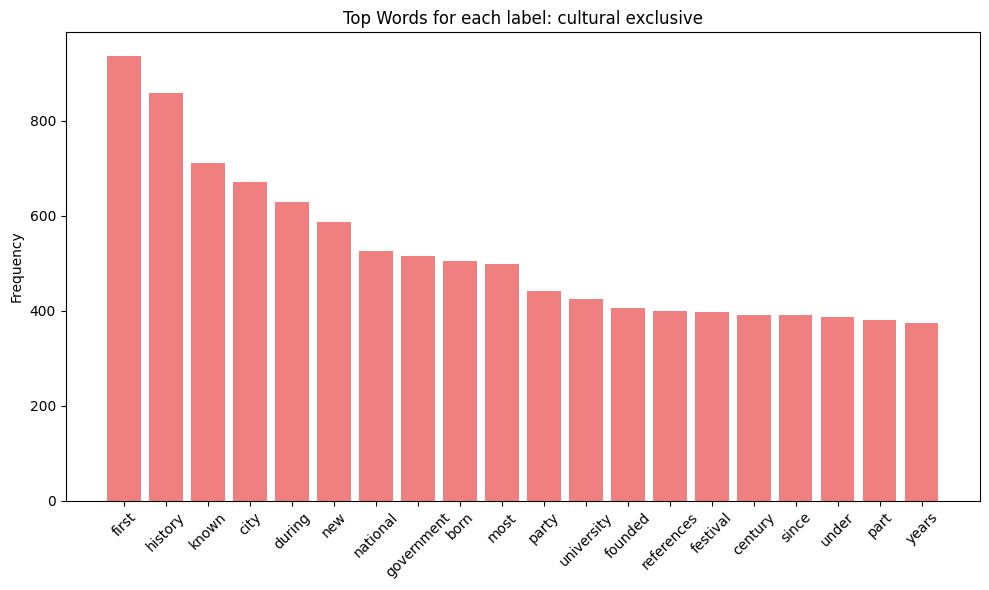

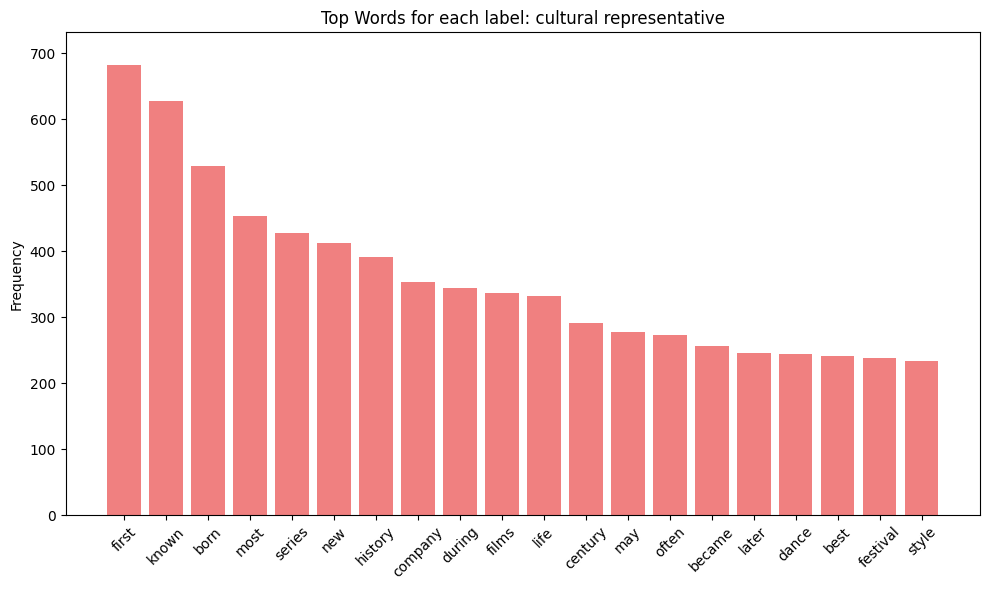

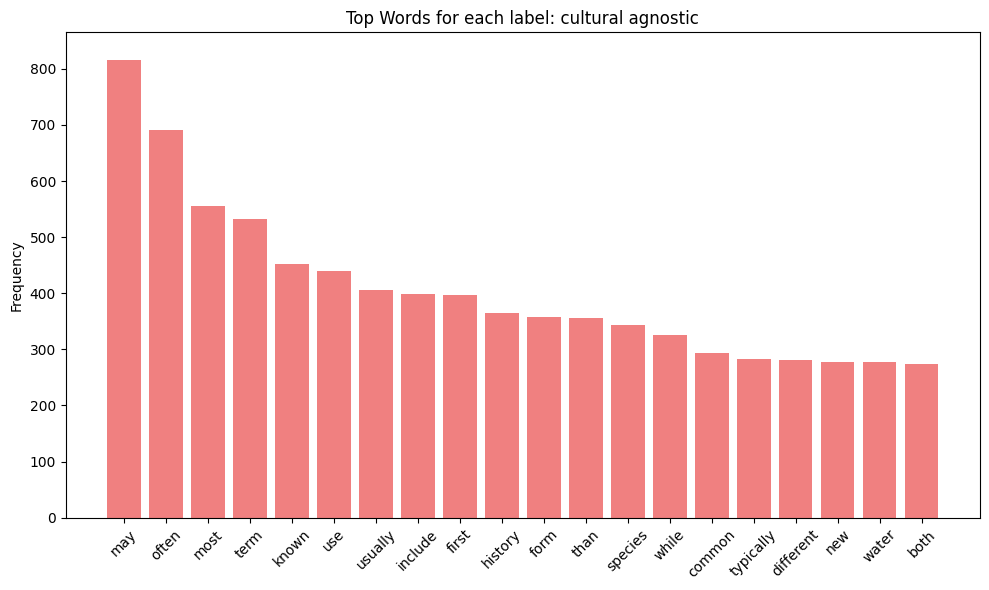

In [7]:
analyze_label_words(train_descriptions_path)

In [4]:
# Plot histogram for a selected feature
def plot_histogram_for_selected_feature(selected_feature, xlim_graph):
  sns.set_theme(style="whitegrid")
  df_train[selected_feature] = pd.to_numeric(df_train[selected_feature], errors='coerce').fillna(0).astype(int)
  # Create a figure with one subplot for each label
  fig, axes = plt.subplots(1, len(labels), figsize=(18, 5), sharey=True)  # 1 row, N columns
  for ax, label in zip(axes, labels):
      subset = df_train[df_train['label'] == label]

      # Limit selected to a maximum of 10
      subset = subset[subset[selected_feature] <= xlim_graph]

      # Plot histogram on the corresponding axis
      sns.histplot(
          data=subset,
          x=selected_feature,
          bins=range(0, xlim_graph+1),
          stat="density",
          discrete=True,
          shrink=0.8,
          ax=ax
      )
      ax.set_title(f'{label}')
      ax.set_xlabel(f'{selected_feature}')
      ax.set_ylabel('density')
      ax.set_xticks(range(0, xlim_graph + 1, 2))

  plt.suptitle(f'Distribution of {selected_feature} per label', fontsize=16)
  plt.tight_layout()
  plt.show()

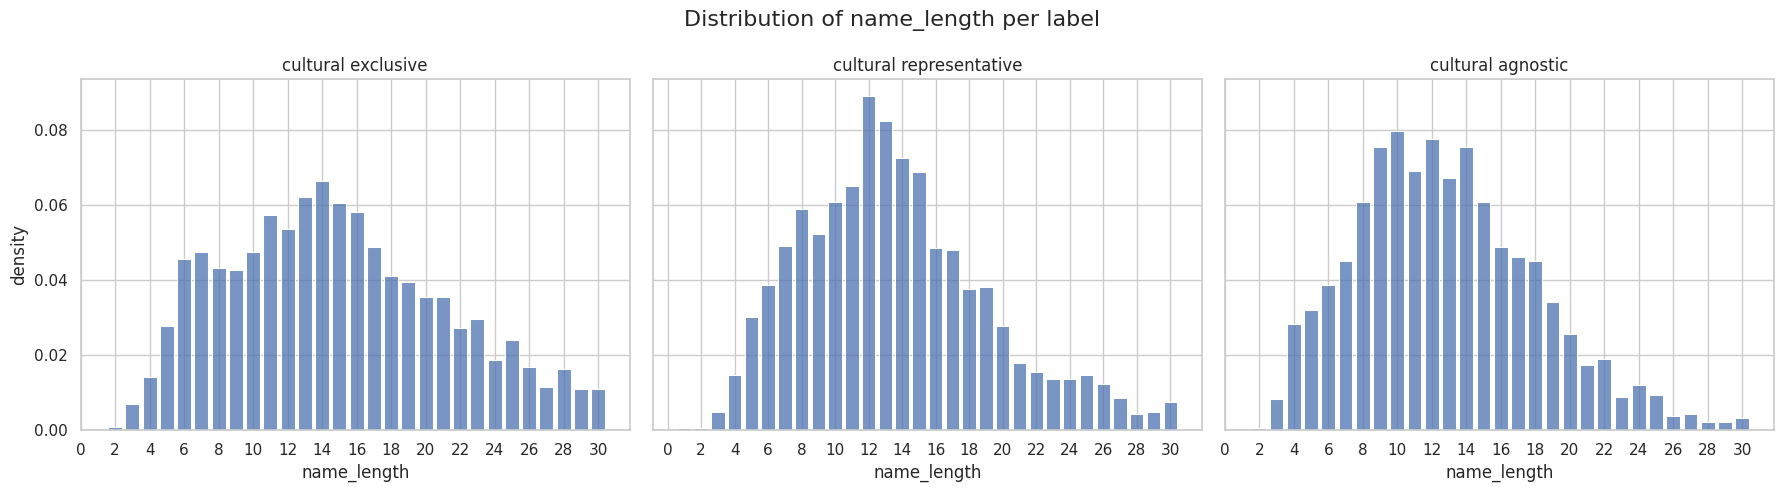

In [10]:
selected_feature = 'name_length'
xlim_graph = 30
plot_histogram_for_selected_feature(selected_feature, xlim_graph)

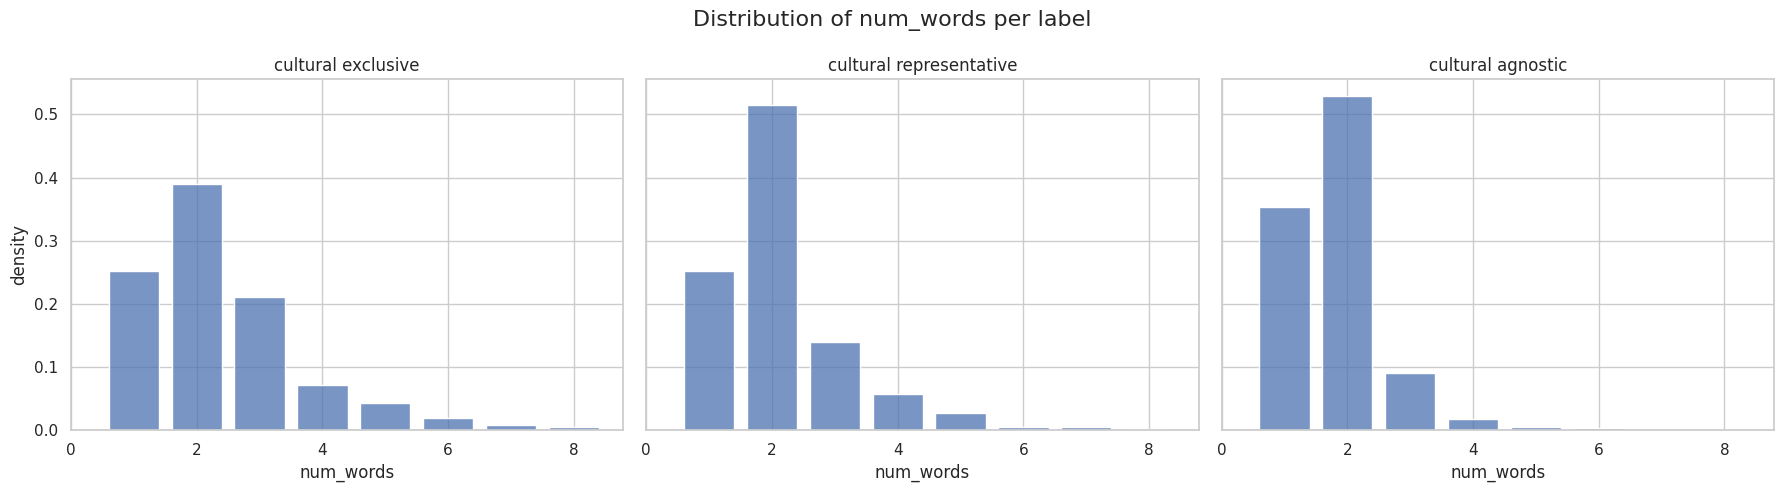

In [11]:
selected_feature = 'num_words'
xlim_graph = 8
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


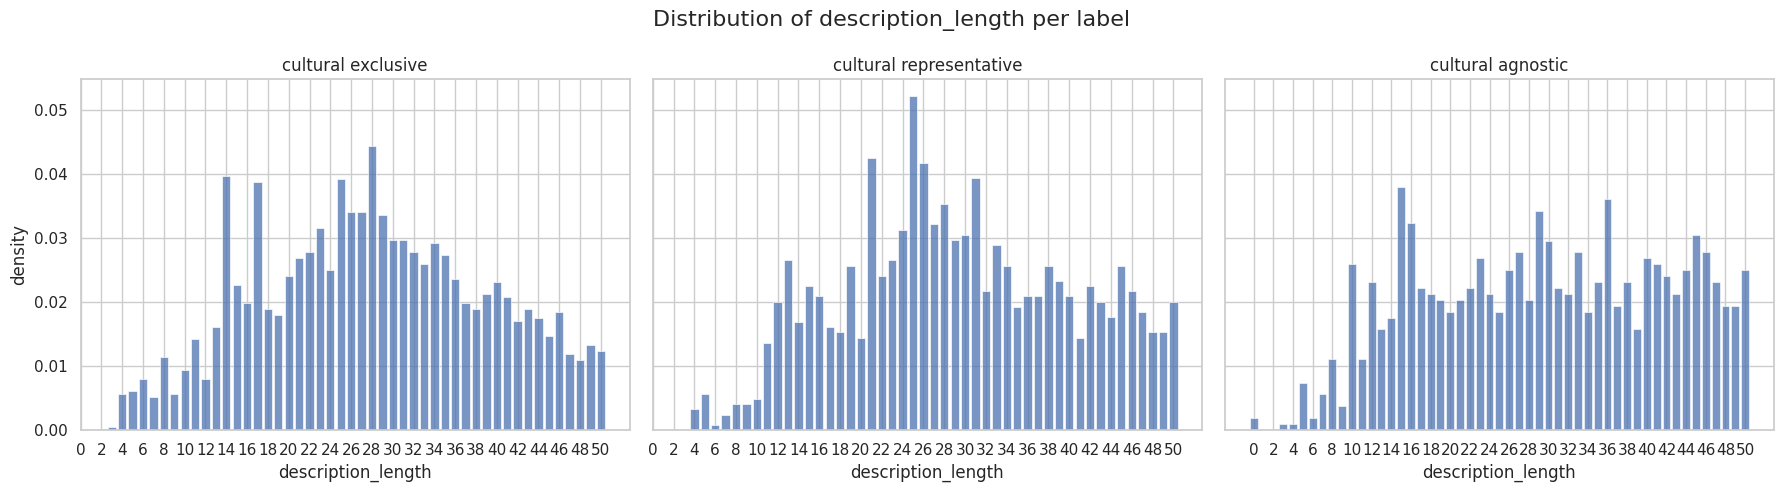

In [12]:
selected_feature = 'description_length'
xlim_graph = 50
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


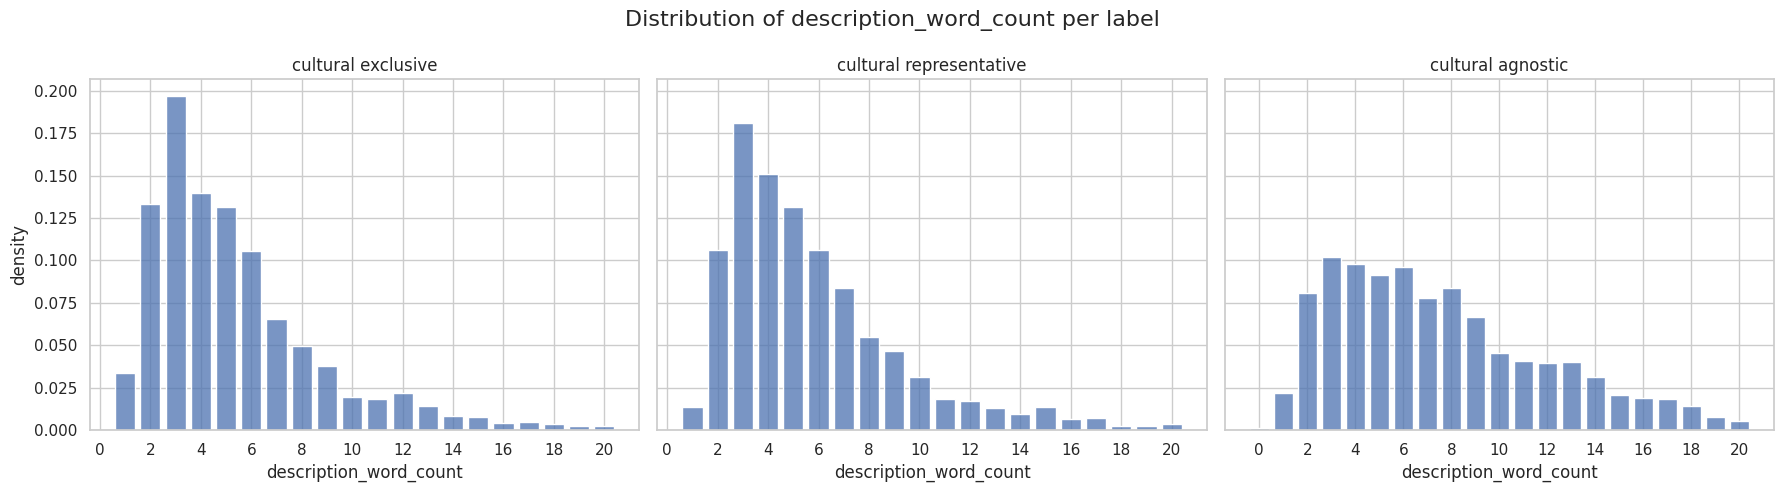

In [13]:
selected_feature = 'description_word_count'
xlim_graph = 20
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


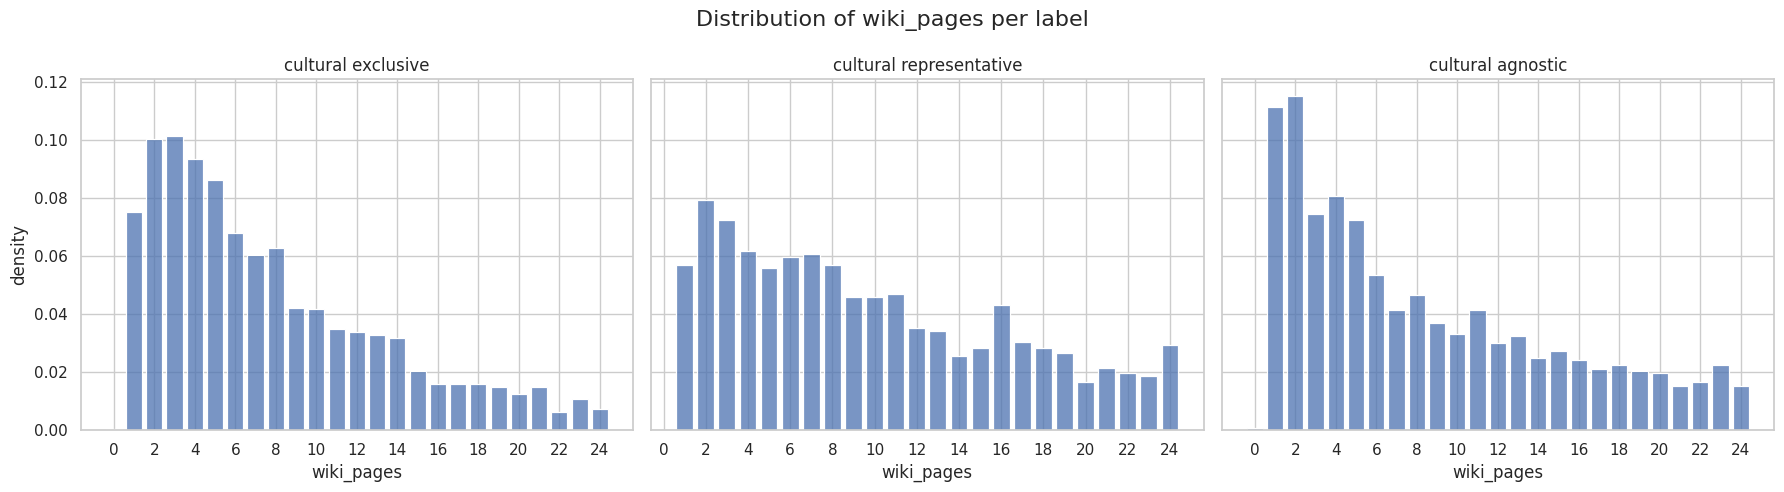

In [14]:
selected_feature = 'wiki_pages'
xlim_graph = 24
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


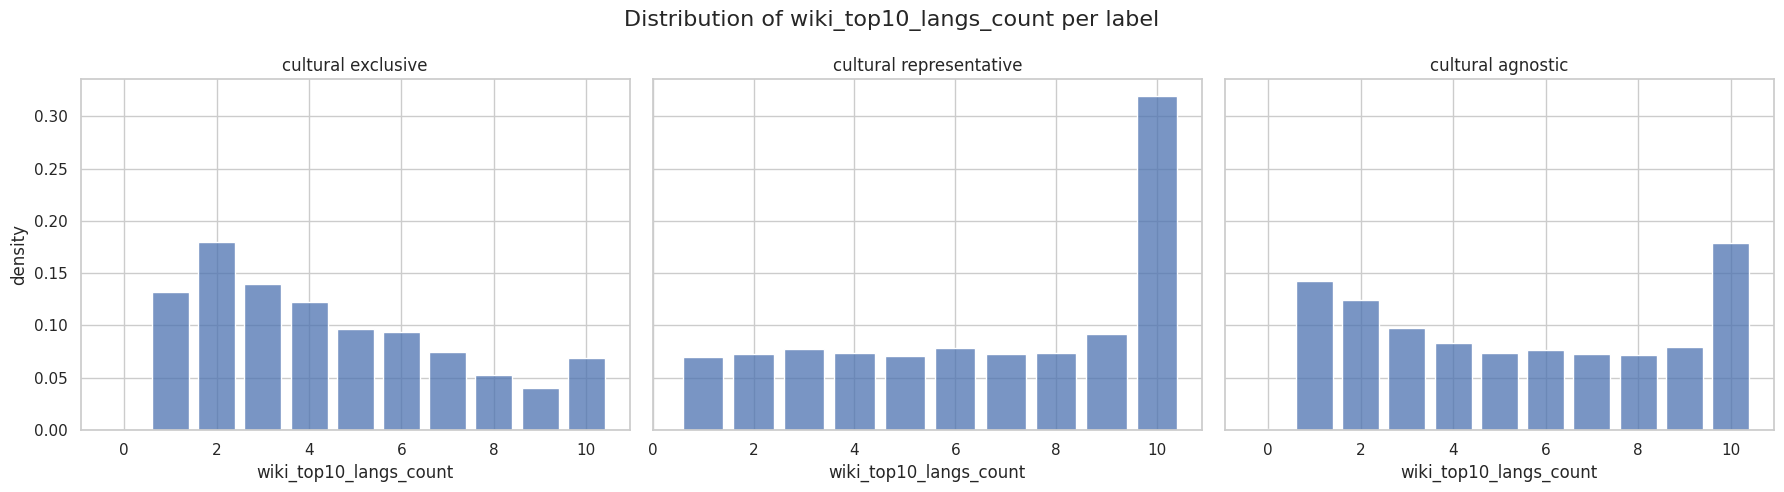

In [15]:
selected_feature = 'wiki_top10_langs_count'
xlim_graph = 10
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


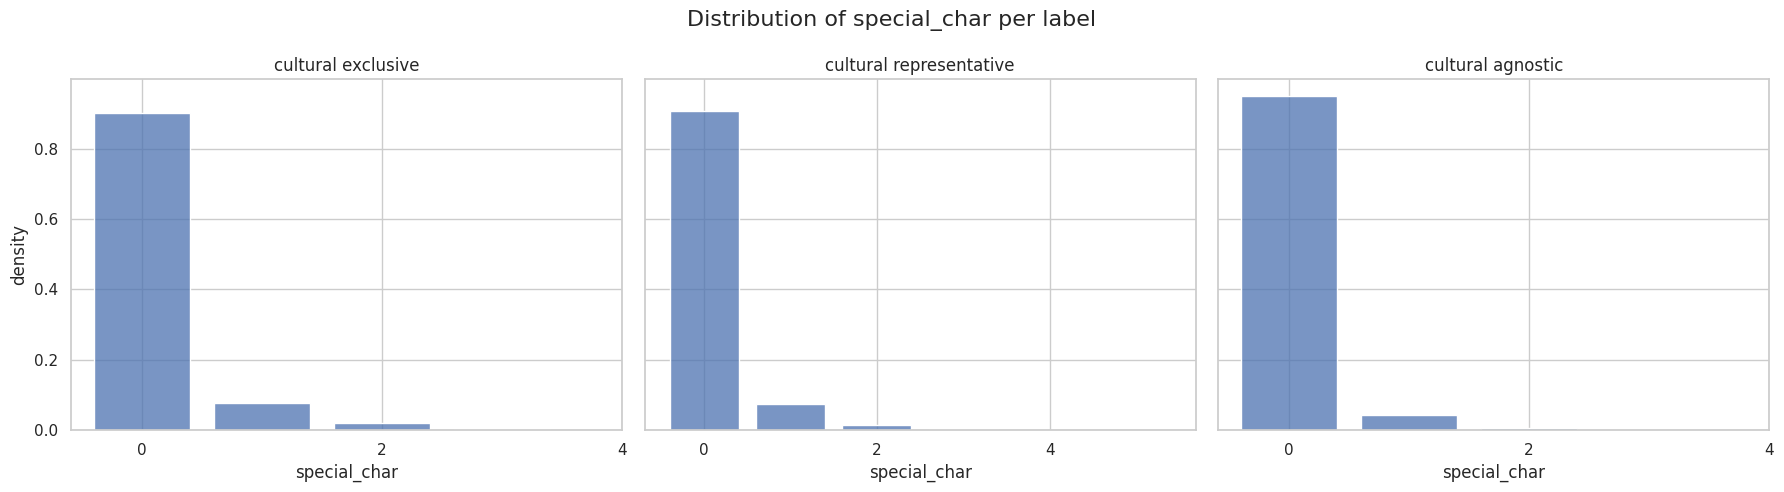

In [16]:
selected_feature = 'special_char'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


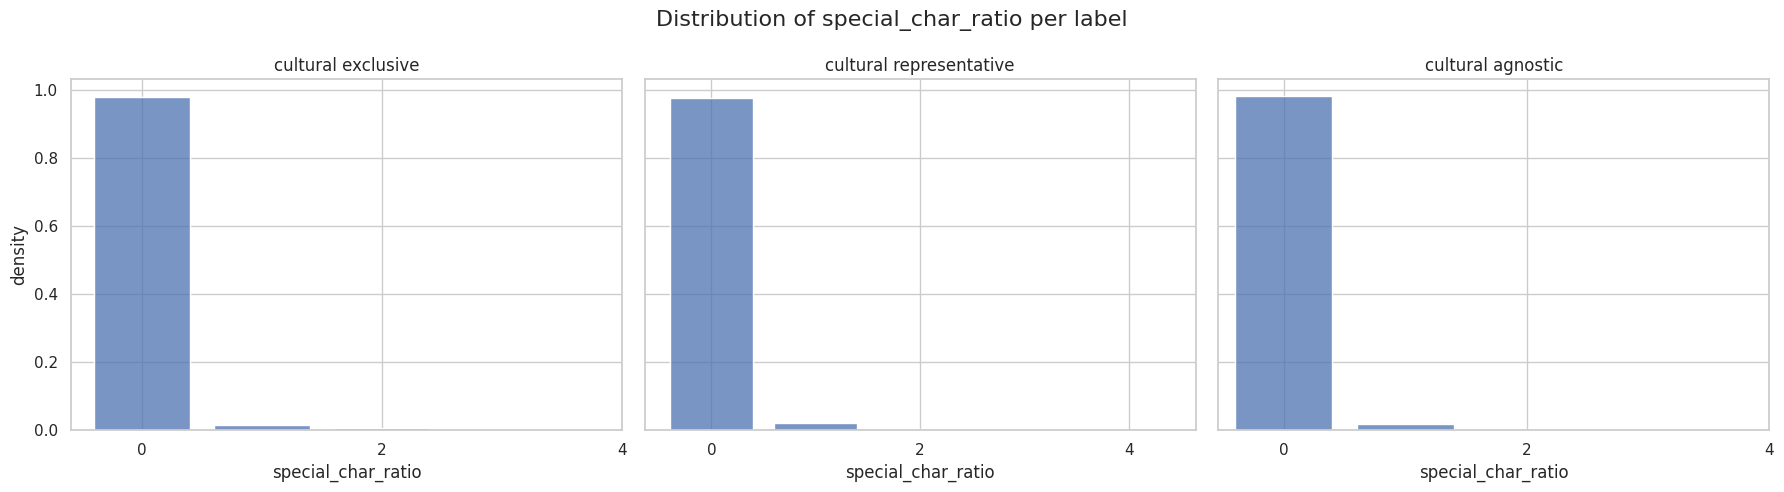

In [17]:
selected_feature = 'special_char_ratio'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


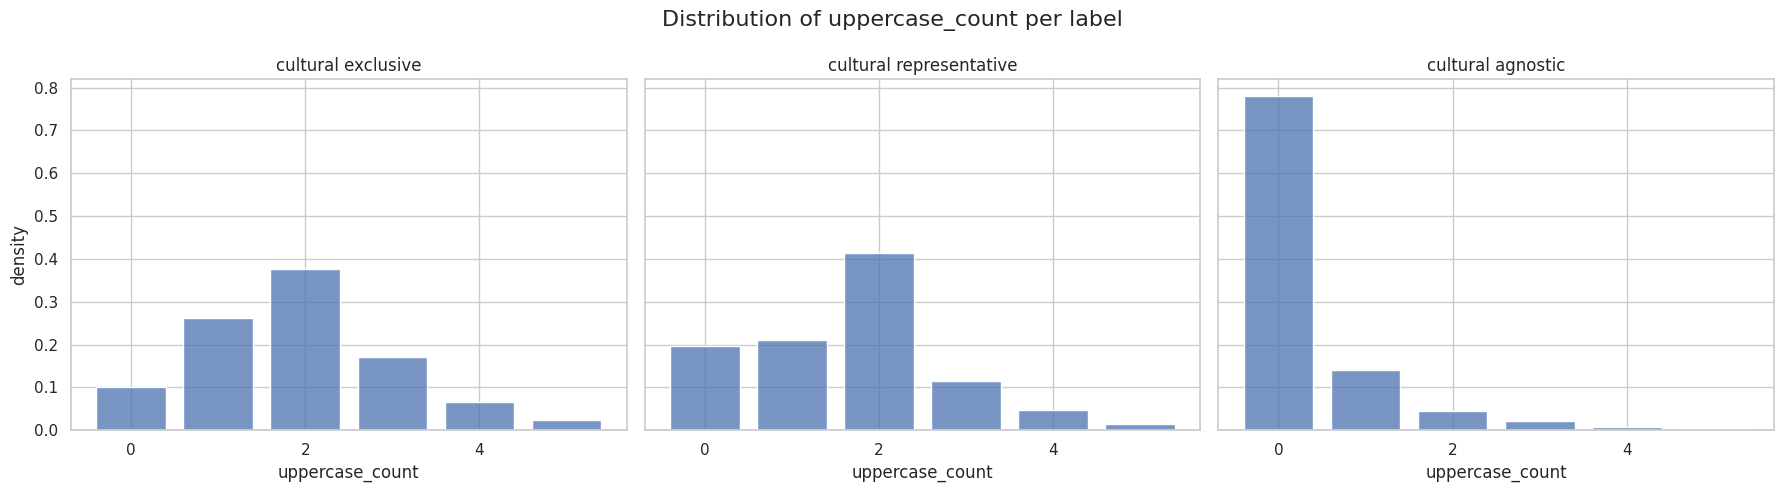

In [18]:
selected_feature = 'uppercase_count'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


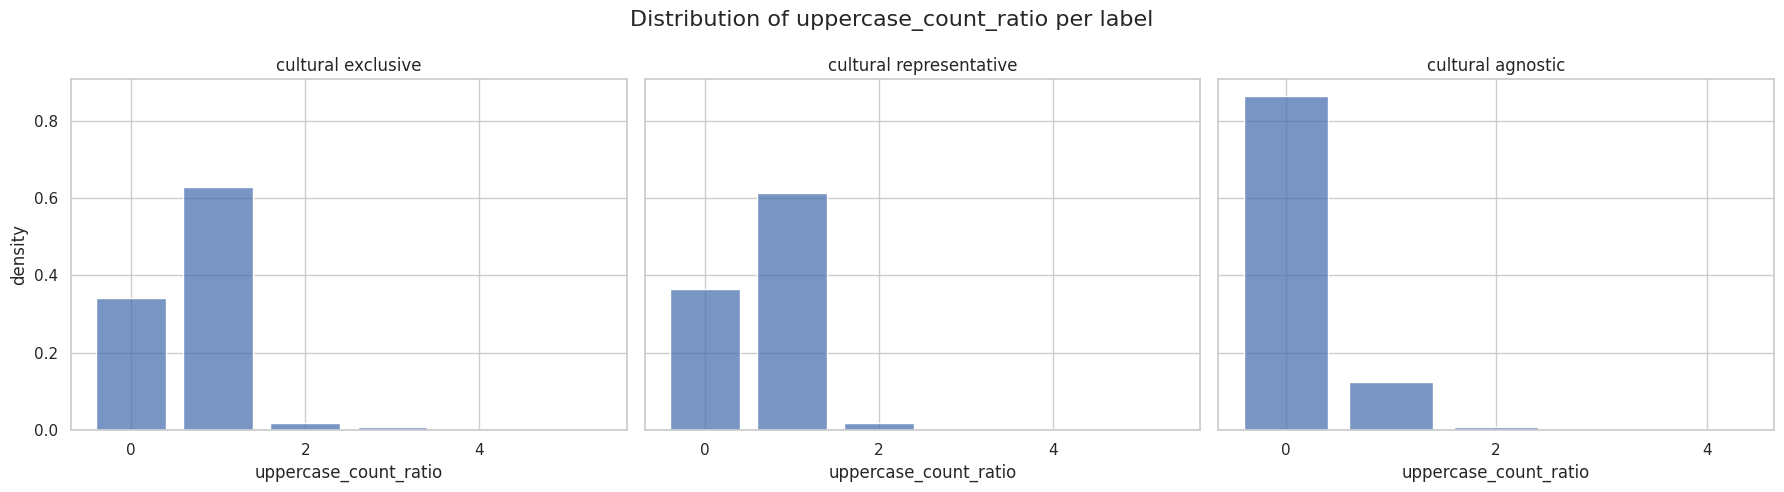

In [19]:
selected_feature = 'uppercase_count_ratio'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


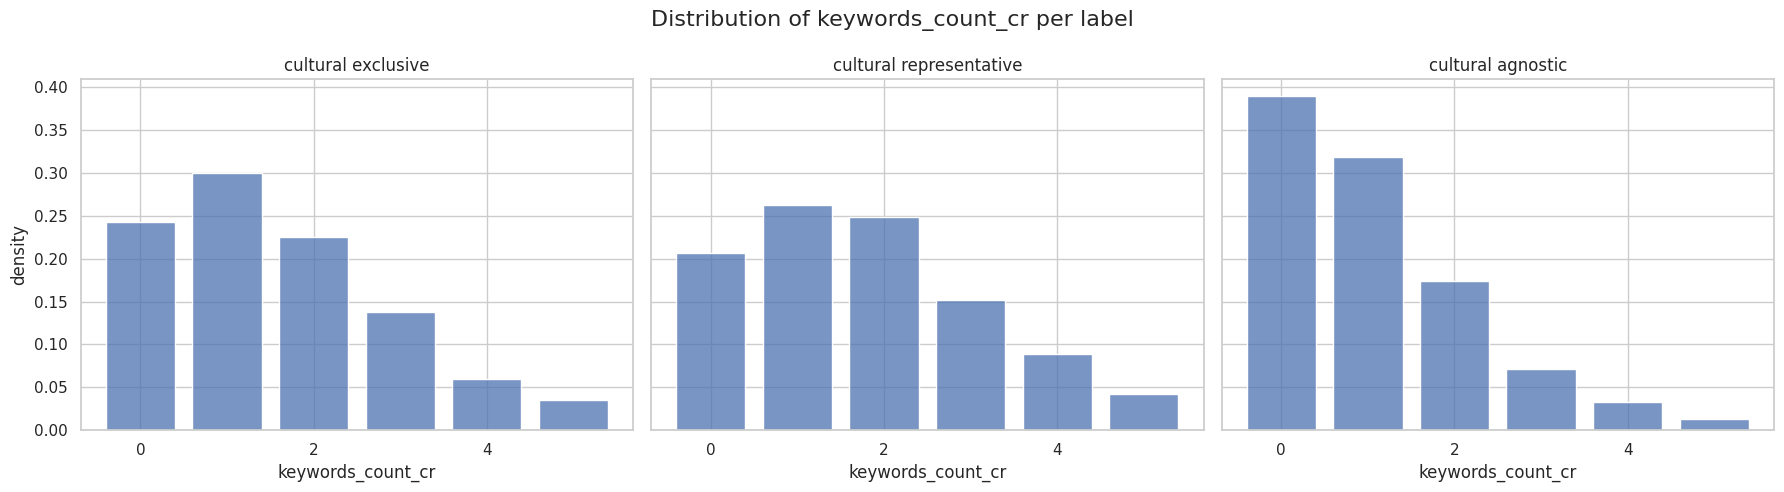

In [20]:
selected_feature = 'keywords_count_cr'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


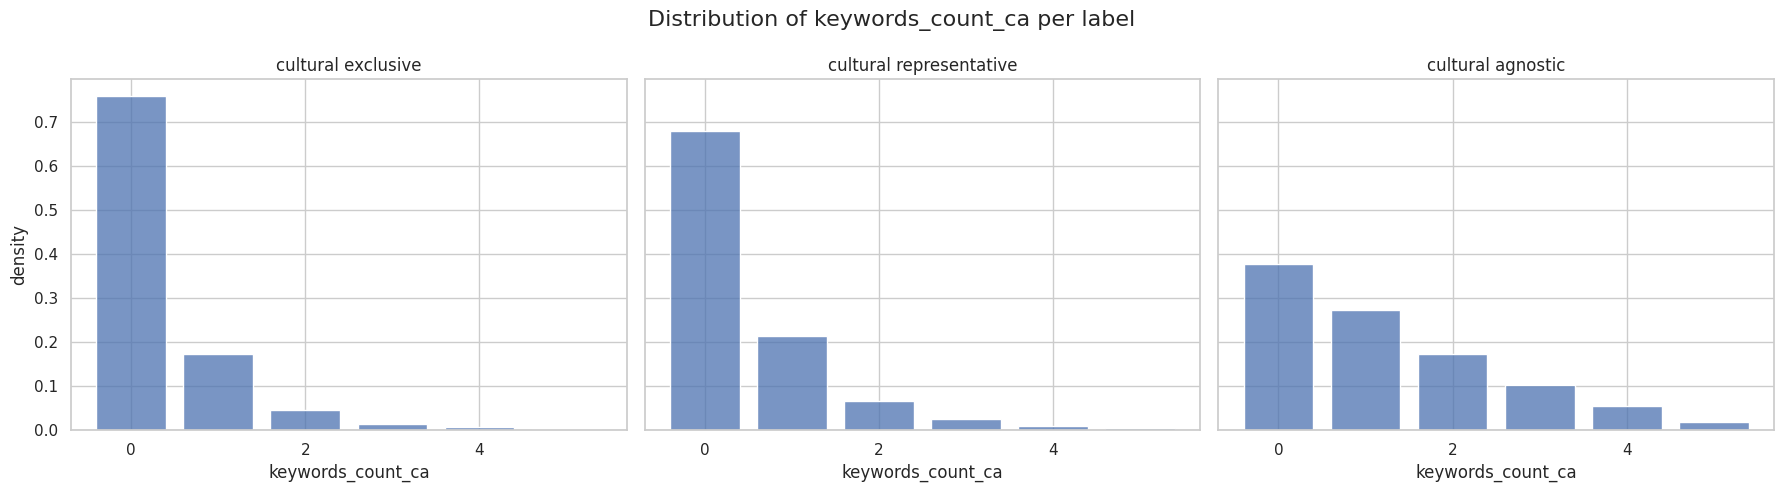

In [21]:
selected_feature = 'keywords_count_ca'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


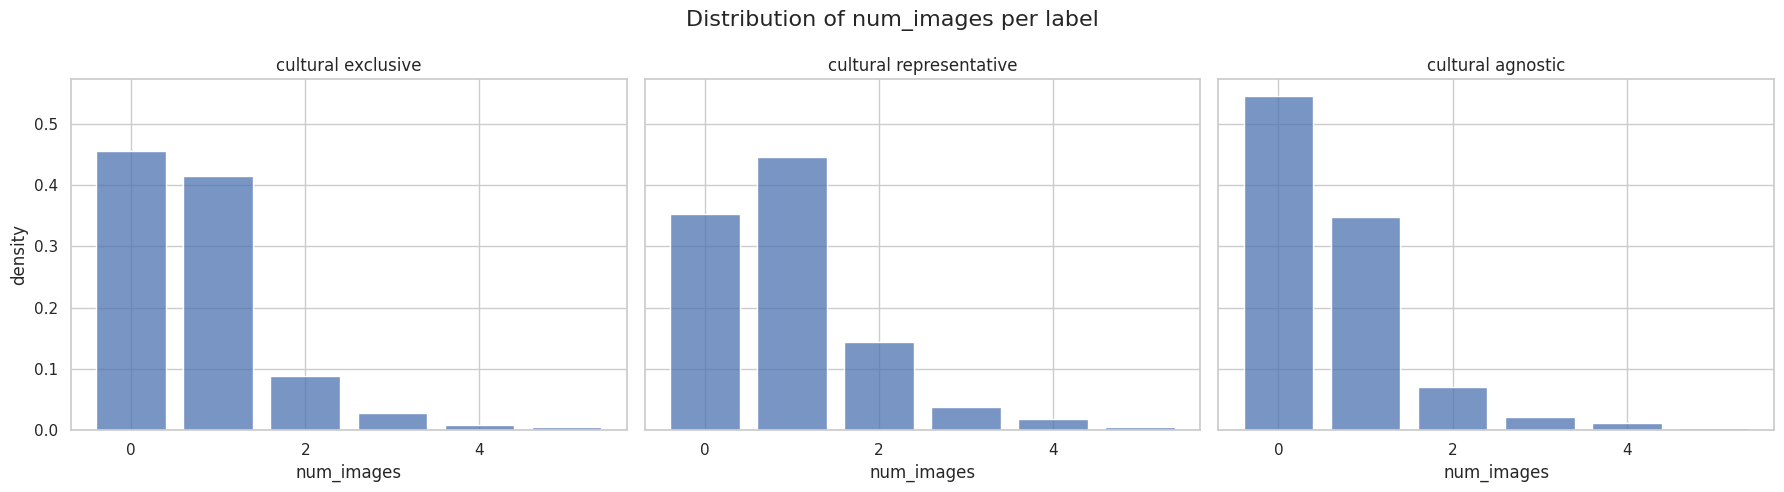

In [22]:
#TODO eliminare questa feature
selected_feature = 'num_images'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


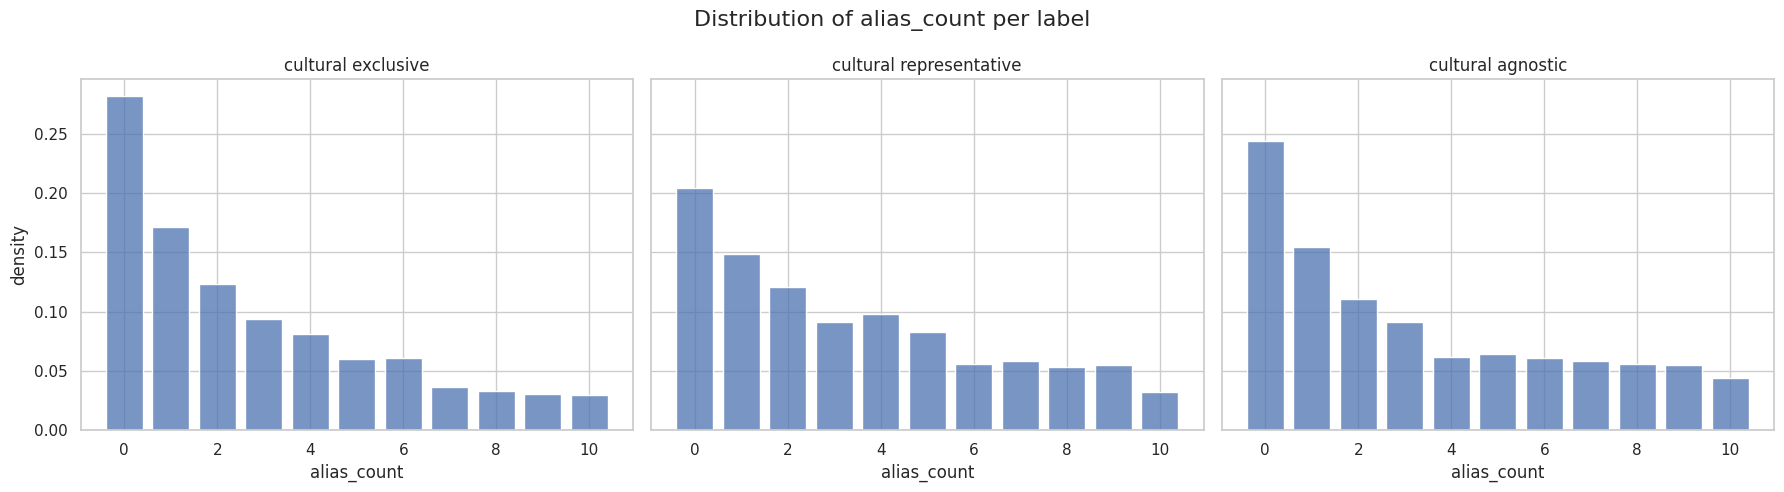

In [23]:
selected_feature = 'alias_count'
xlim_graph = 10
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


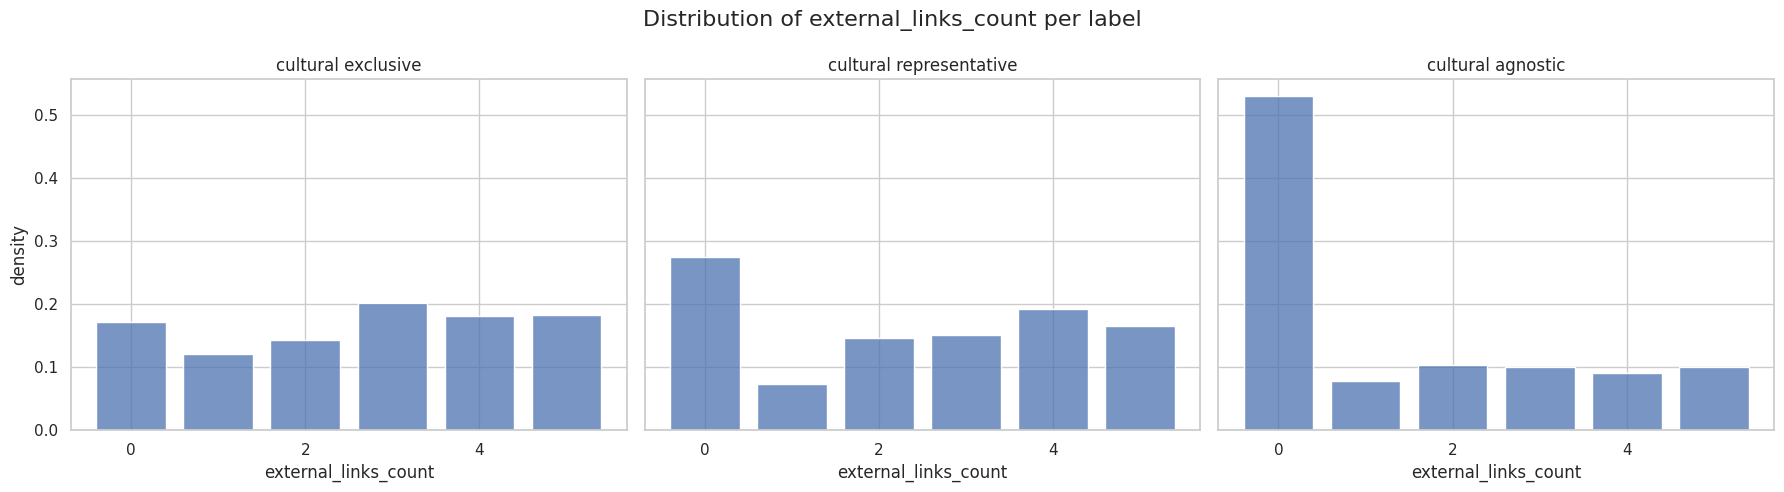

In [24]:
selected_feature = 'external_links_count'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


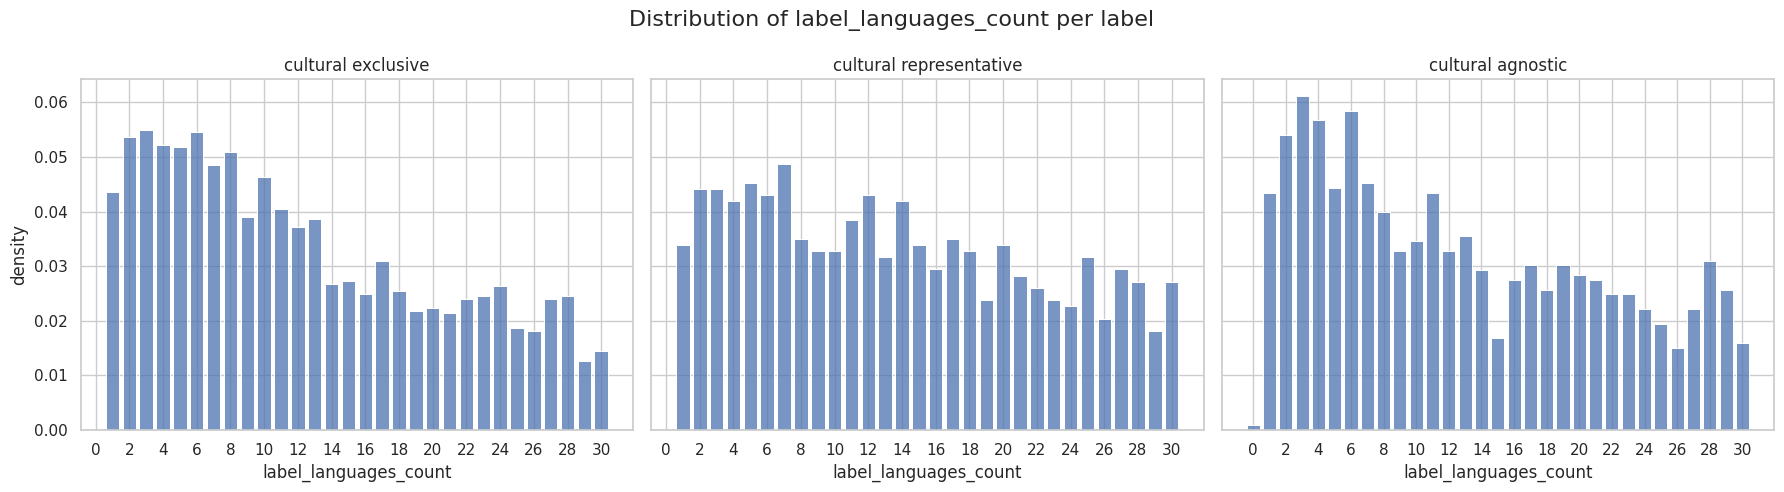

In [25]:
selected_feature = 'label_languages_count'
xlim_graph = 30
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


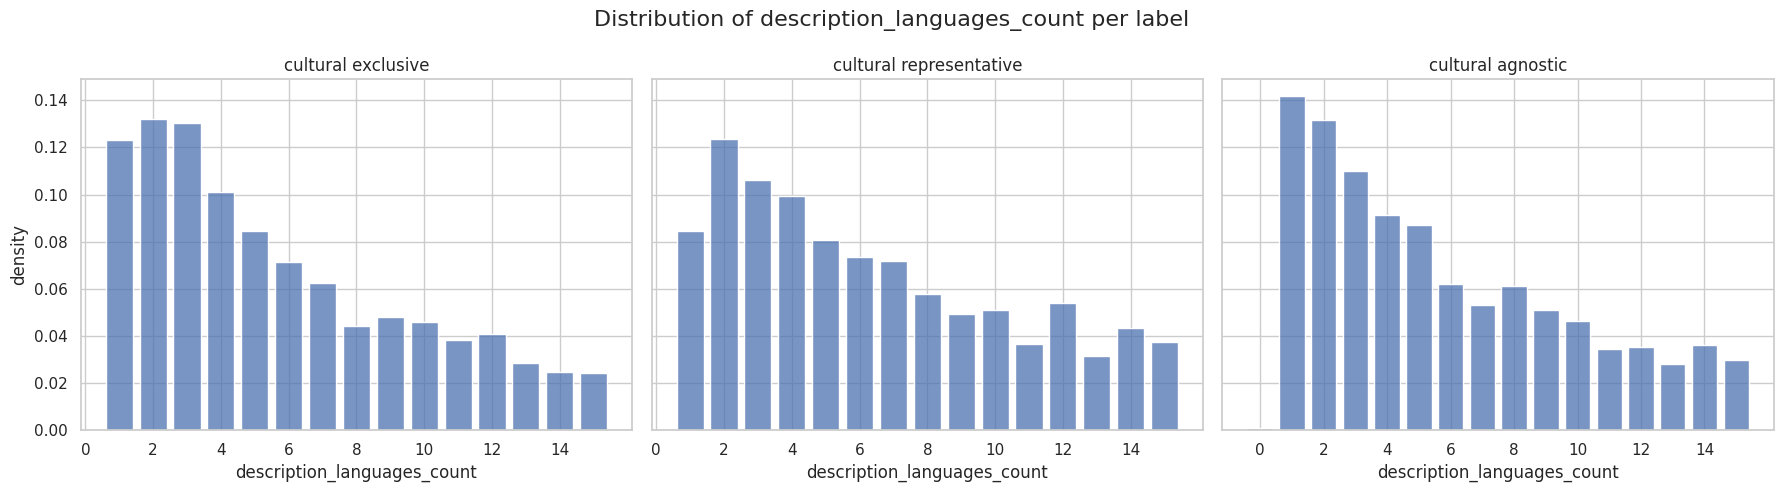

In [26]:
selected_feature = 'description_languages_count'
xlim_graph = 15
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


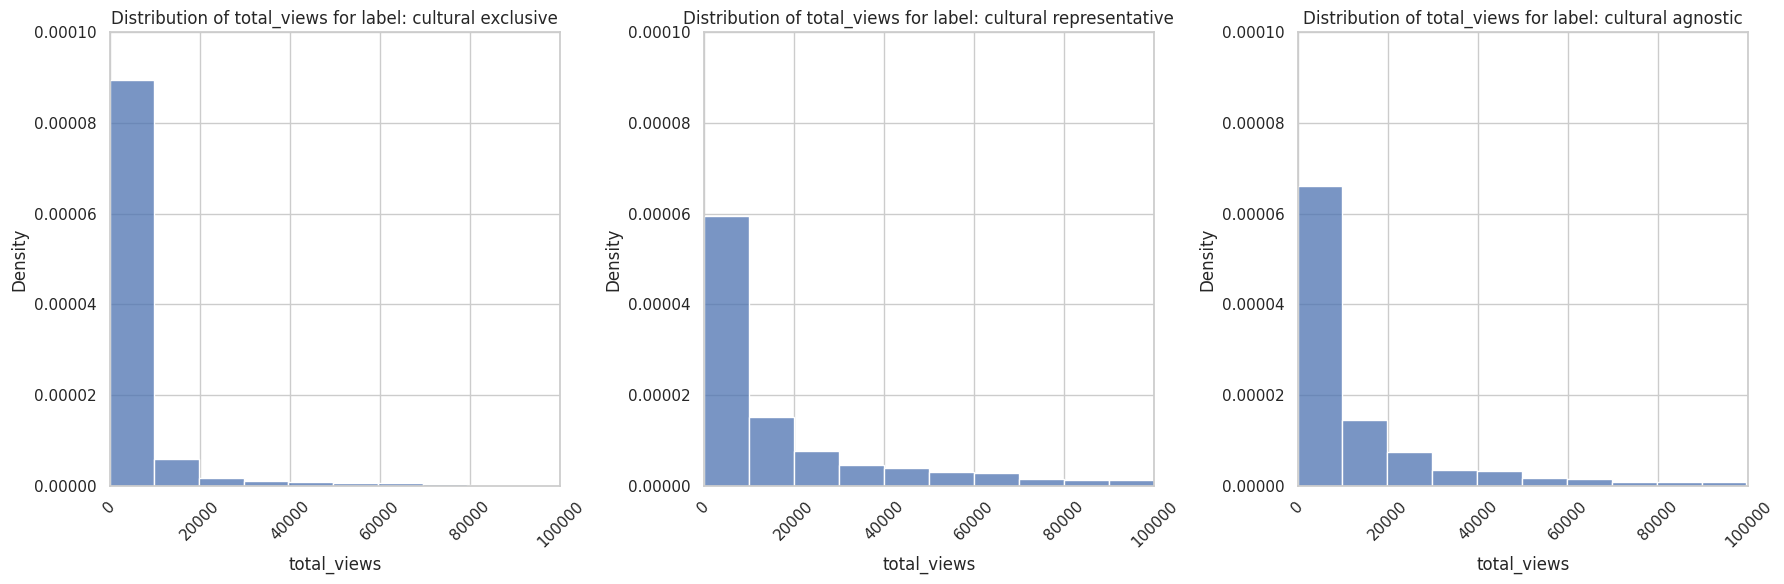

In [27]:
selected_feature = 'total_views'
xlim_graph = 100000
plt.figure(figsize=(18, 6))

for i, label in enumerate(labels, 1):
    plt.subplot(1, 3, i, )
    subset = df_train[df_train['label'] == label]
    subset = subset[subset[selected_feature] <= xlim_graph]


    sns.histplot(subset[selected_feature], kde=False, bins=10, stat='density')
    plt.title(f"Distribution of {selected_feature} for label: {label}")
    plt.xlabel(selected_feature)
    plt.ylabel('Density')

    plt.xlim(0, xlim_graph)
    plt.ylim(0, 0.0001)
    plt.xticks(rotation=45)

plt.tight_layout()

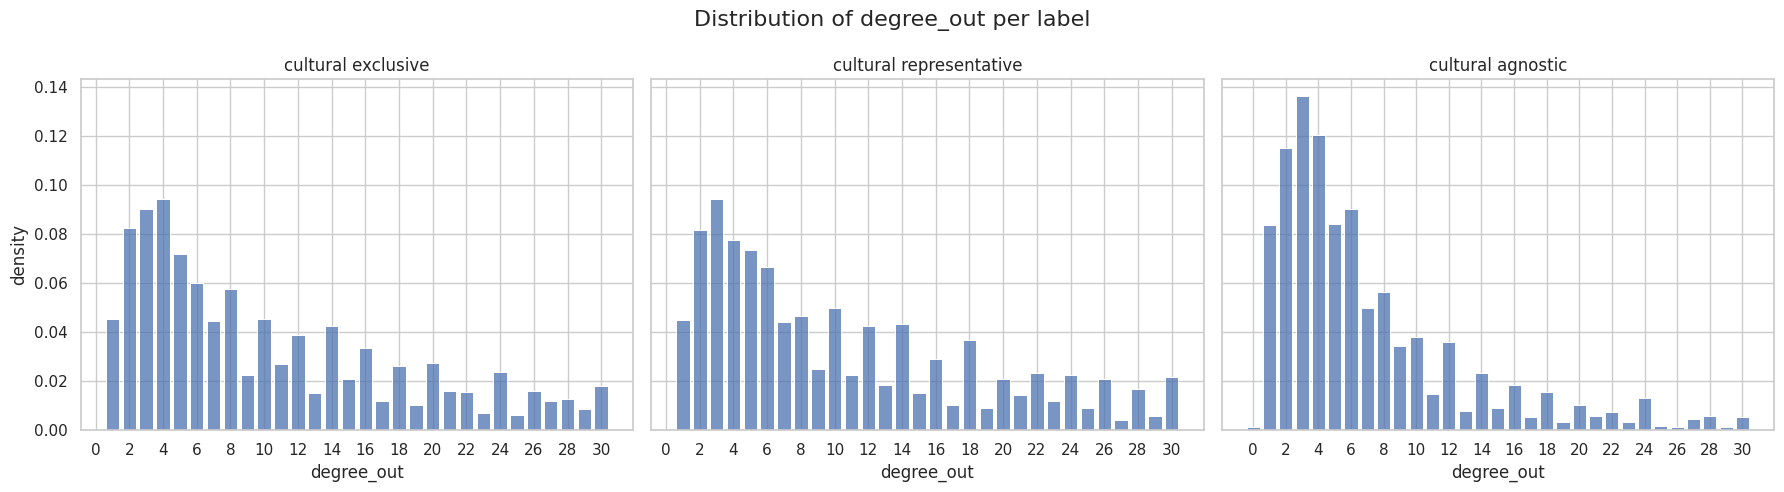

In [28]:
selected_feature = 'degree_out'
xlim_graph = 30
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


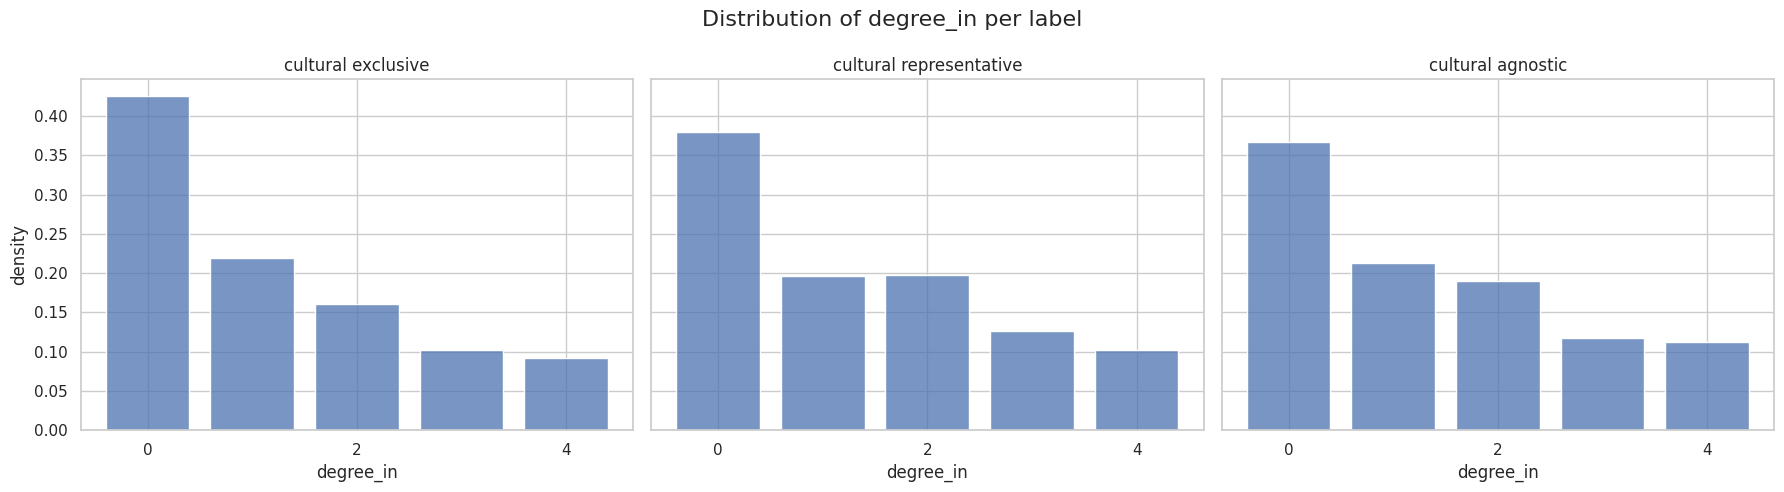

In [29]:
# TODO eliminare feature
selected_feature = 'degree_in'
xlim_graph = 4
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


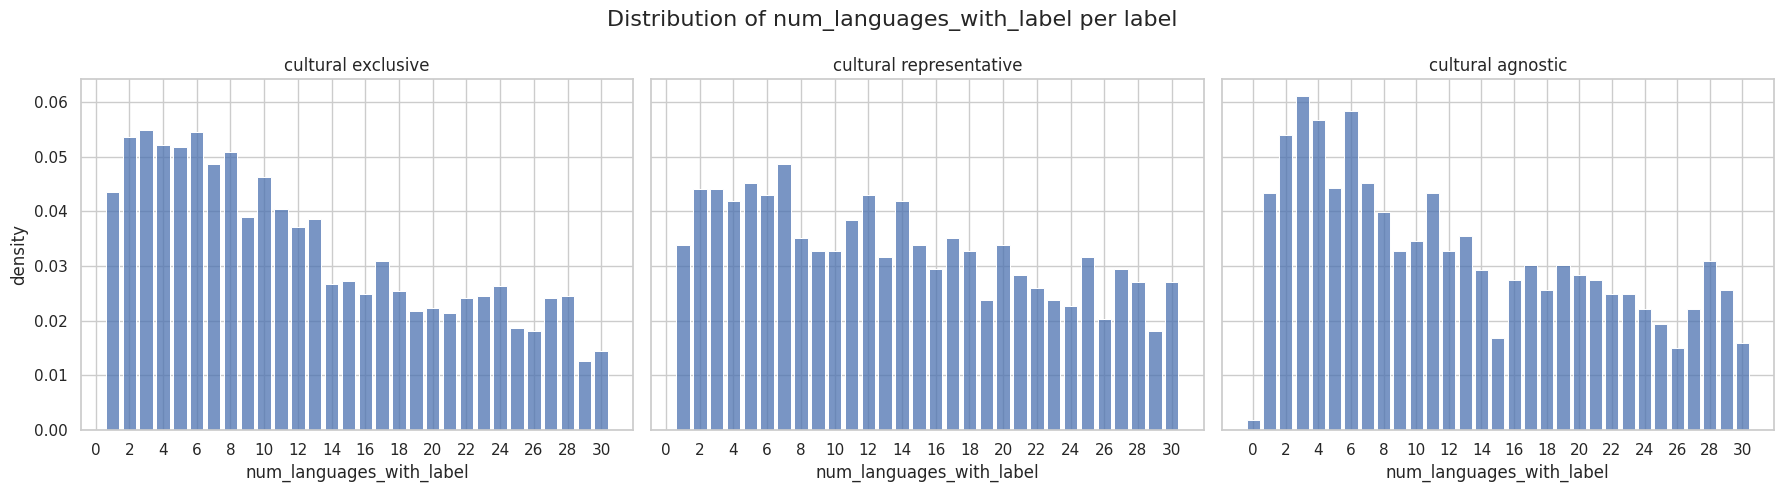

In [30]:
selected_feature = 'num_languages_with_label'
xlim_graph = 30
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


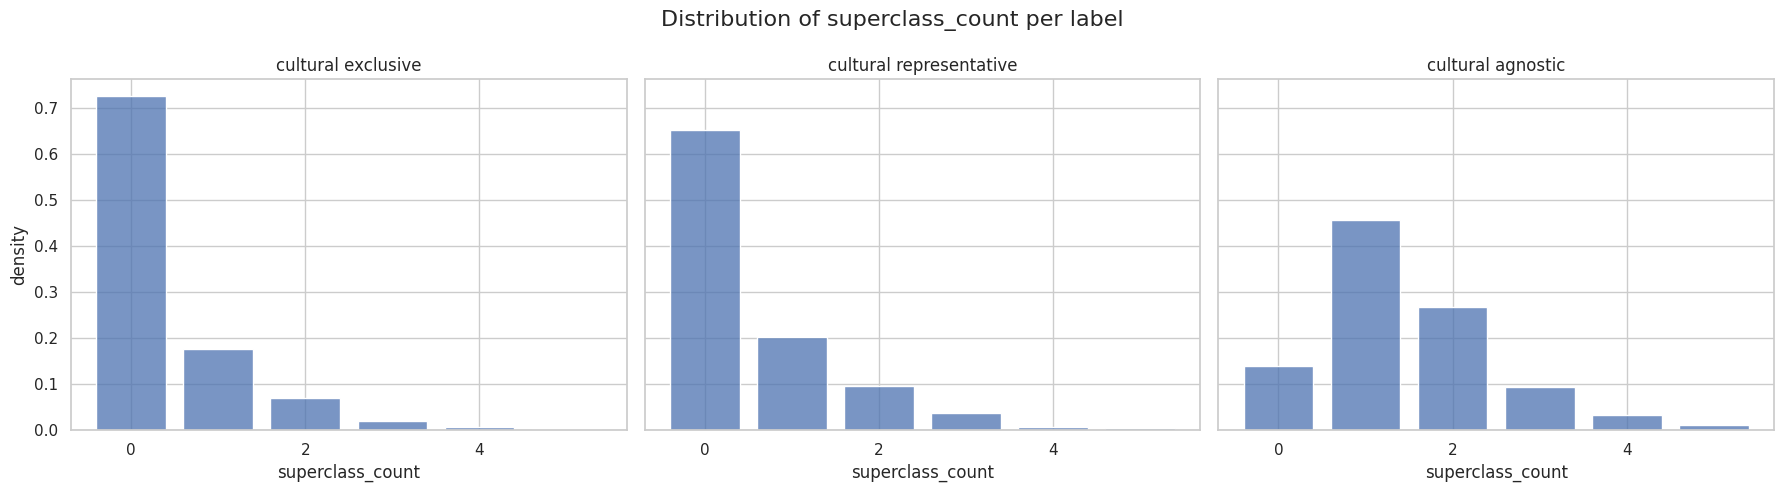

In [31]:
selected_feature = 'superclass_count'
xlim_graph = 5
plot_histogram_for_selected_feature(selected_feature, xlim_graph)

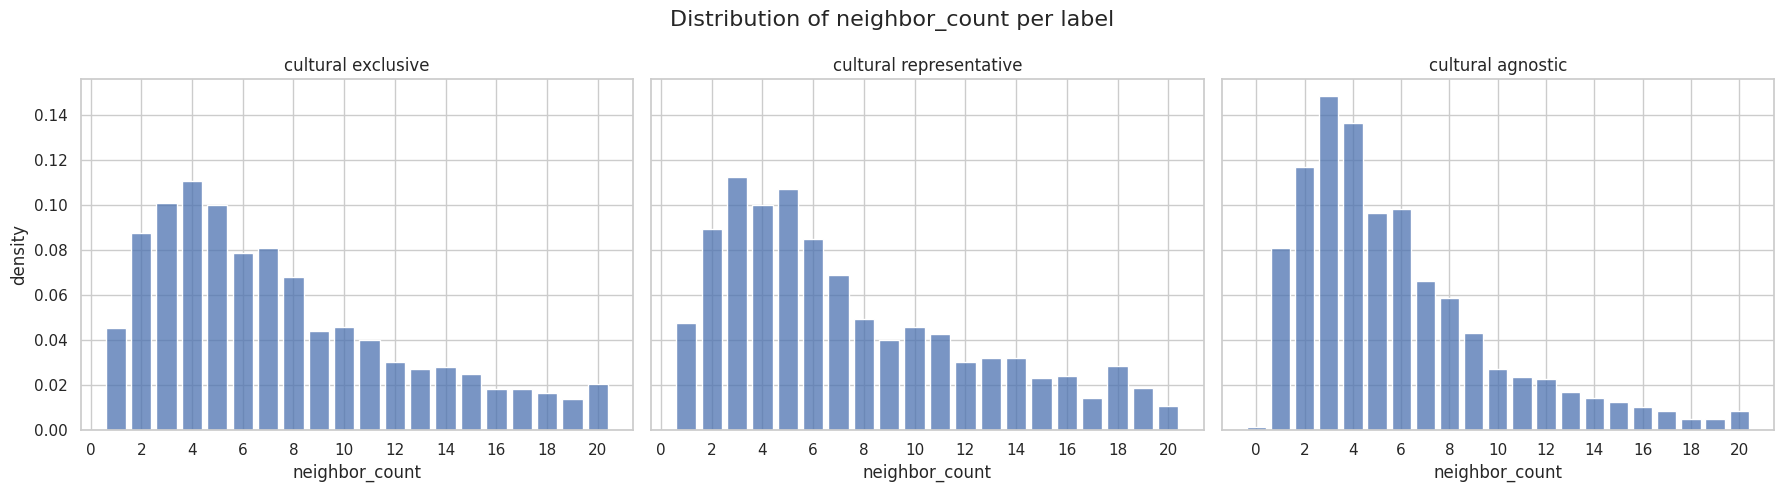

In [32]:
selected_feature = 'neighbor_count'
xlim_graph = 20
plot_histogram_for_selected_feature(selected_feature, xlim_graph)


## Pipeline on Dev Set

In [ ]:
df_dev = pd.read_csv(original_dev_dataset_path)

In [ ]:
print("Saving the first 1000 characters of the Wikipedia description for each item...")
save_first_1000_chars(dataset = df_dev,
                      output_file = dev_description_path)

Saving the first 1000 characters of the Wikipedia description for each item...
[1] Processing: http://www.wikidata.org/entity/Q15786
Entity ID: Q15786
[2] Processing: http://www.wikidata.org/entity/Q268530
Entity ID: Q268530
[3] Processing: http://www.wikidata.org/entity/Q216153
Entity ID: Q216153
[4] Processing: http://www.wikidata.org/entity/Q593
Entity ID: Q593
[5] Processing: http://www.wikidata.org/entity/Q192185
Entity ID: Q192185
[6] Processing: http://www.wikidata.org/entity/Q265890
Entity ID: Q265890
[7] Processing: http://www.wikidata.org/entity/Q305718
Entity ID: Q305718
[8] Processing: http://www.wikidata.org/entity/Q337267
Entity ID: Q337267
[9] Processing: http://www.wikidata.org/entity/Q15
Entity ID: Q15
[10] Processing: http://www.wikidata.org/entity/Q388170
Entity ID: Q388170
[11] Processing: http://www.wikidata.org/entity/Q11453
Entity ID: Q11453
[12] Processing: http://www.wikidata.org/entity/Q11436
Entity ID: Q11436
[13] Processing: http://www.wikidata.org/entity/Q5

In [ ]:
print("Augmenting the dataset...")
df_dev_augmented = pipeline_augmentation_dataset(dataset = df_dev,
                                                  wiki_description_file_path = dev_description_path,
                                                  keywords_cr = keywords_cr,
                                                  keywords_ca = keywords_ca,
                                                  wiki_file_path = dev_wiki_file_path)

df_dev_augmented.to_csv(augmented_dev_dataset_path, index=False)

Augmenting the dataset...
add_name_length
add_count_num_of_words
add_description_length
add_description_word_count
add_wikipages_language_info


Processing Wikidata entities: 100%|██████████| 300/300 [01:16<00:00,  3.93it/s]


add_special_chars_count
add_uppercase_number
add_keywords_count_cr
add_keywords_count_ca
add_num_images


100%|██████████| 300/300 [01:02<00:00,  4.80it/s]


add_alias_count_to_df


100%|██████████| 300/300 [01:03<00:00,  4.70it/s]


add_external_link_count


100%|██████████| 300/300 [02:04<00:00,  2.41it/s]


add_language_count_from_labels


Processing label/description languages: 100%|██████████| 300/300 [01:13<00:00,  4.07it/s]


dataset_with_wikipedia_views
Found 300 unique Wikidata IDs
Skipped Q216929 - title missing/problematic/not found

Saved view stats to '/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/dev_wiki_file_path.csv'
augment_with_wikidata_features


Extracting features from Wikidata: 100%|██████████| 300/300 [05:45<00:00,  1.15s/it]

Merging extracted features with original dataset...
[SUCCESS] Merge completed successfully.


In [ ]:
df_dev_augmented = union_file_description_dataset(augmented_dev_dataset_path, dev_description_path)

Union Completed


# Training of the models

In [33]:
# Reading of the training dataset
df_train = pd.read_csv(augmented_train_dataset_path)
df_train.fillna(0)
df_train.head()

,item,name,description,type,category,subcategory,label,name_length,num_words,wiki_pages,...,qid,degree_out,degree_in,label_length,description_length,description_word_count,num_languages_with_label,superclass_count,neighbor_count,text
0,http://www.wikidata.org/entity/Q32786,916,2012 film by M. Mohanan,entity,films,film,cultural exclusive,3,1,6,...,Q32786,10,0,3.0,23.0,5.0,9.0,0.0,10.0,916 is a 2012 Indian Malayalam-language drama...
1,http://www.wikidata.org/entity/Q371,!!!,American dance-punk band from California,entity,music,musical group,cultural representative,3,1,29,...,Q371,9,15,3.0,40.0,5.0,54.0,0.0,9.0,"!!! ( ch(i)k-ch(i)k-ch(i)k), also known as Chk..."
2,http://www.wikidata.org/entity/Q3729947,¡Soborno!,Mort & Phil comic,entity,comics and anime,comics,cultural representative,9,1,4,...,Q3729947,8,0,9.0,17.0,3.0,5.0,0.0,8.0,¡Soborno! (English: Bribery!) is a 1977 comic ...
3,http://www.wikidata.org/entity/Q158611,+44,American band,entity,music,musical group,cultural representative,3,1,37,...,Q158611,10,9,3.0,13.0,2.0,38.0,0.0,10.0,+44 (read as Plus Forty-four) was an American ...
4,http://www.wikidata.org/entity/Q280375,1 Monk Street,"building in Monmouth, Wales",entity,architecture,building,cultural exclusive,13,3,2,...,Q280375,7,1,13.0,27.0,4.0,3.0,0.0,7.0,"1 Monk Street, Monmouth was built as a Working..."


In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6251 entries, 0 to 6250
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   item                         6251 non-null   object 
 1   name                         6251 non-null   object 
 2   description                  6251 non-null   object 
 3   type                         6251 non-null   object 
 4   category                     6251 non-null   object 
 5   subcategory                  6251 non-null   object 
 6   label                        6251 non-null   object 
 7   name_length                  6251 non-null   int64  
 8   num_words                    6251 non-null   int64  
 9   wiki_pages                   6251 non-null   int64  
 10  wiki_langs                   6249 non-null   object 
 11  wiki_top10_langs_count       6251 non-null   int64  
 12  special_char                 6251 non-null   int64  
 13  special_char_ratio

In [35]:
# Reading of the dev set
df_dev = pd.read_csv(augmented_dev_dataset_path)
df_dev.fillna(0)
df_dev.head()

,item,name,description,type,category,subcategory,label,name_length,num_words,description_length,...,wikidata_id,total_views,qid,degree_out,degree_in,label_length,num_languages_with_label,superclass_count,neighbor_count,text
0,http://www.wikidata.org/entity/Q15786,1. FC Nürnberg,"German sports club based in Nuremberg, Bavaria",entity,sports,sports club,cultural representative,14,3,46,...,Q15786,43464.0,Q15786,69,6870,14,75,0,29,1. Fußball-Club Nürnberg Verein für Leibesübun...
1,http://www.wikidata.org/entity/Q268530,77 Records,UK record label,entity,music,record label,cultural exclusive,10,2,15,...,Q268530,316.0,Q268530,8,7,10,10,0,8,77 Records was a British record company and la...
2,http://www.wikidata.org/entity/Q216153,A Bug's Life,1998 animated film directed by John Lasseter a...,entity,comics and anime,animated film,cultural representative,12,3,63,...,Q216153,167804.0,Q216153,146,102,12,121,0,74,A Bug's Life (stylized in all lowercase) is a ...
3,http://www.wikidata.org/entity/Q593,A Gang Story,2011 film by Olivier Marchal,entity,films,film,cultural exclusive,12,3,28,...,Q593,1989.0,Q593,54,2,12,28,0,54,A Gang Story (French: Les Lyonnais) is a 2011 ...
4,http://www.wikidata.org/entity/Q192185,Aaron Copland,"American composer, composition teacher, writer...",entity,performing arts,choreographer,cultural representative,13,2,73,...,Q192185,54457.0,Q192185,71,108,13,67,0,75,"Aaron Copland (, KOHP-lənd; November 14, 1900 ..."


In [36]:
numeric_features = df_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [f for f in numeric_features if f != 'label']
print(f"Found {len(numeric_features)} numeric features\n")

Found 24 numeric features



In [37]:
numeric_features

['name_length',
 'num_words',
 'wiki_pages',
 'wiki_top10_langs_count',
 'special_char',
 'special_char_ratio',
 'uppercase_count',
 'uppercase_count_ratio',
 'keywords_count_cr',
 'keywords_count_ca',
 'num_images',
 'alias_count',
 'external_links_count',
 'label_languages_count',
 'description_languages_count',
 'total_views',
 'degree_out',
 'degree_in',
 'label_length',
 'description_length',
 'description_word_count',
 'num_languages_with_label',
 'superclass_count',
 'neighbor_count']

# Training of the models

In [38]:
def get_X_y_from_dataset(dataset, features):
    X = dataset[features].fillna(0)
    y = dataset["label"]
    return X, y


In [39]:
X_train, y_train = get_X_y_from_dataset(df_train, numeric_features)
X_dev, y_dev = get_X_y_from_dataset(df_dev, numeric_features)


In [40]:
labels = sorted(list(y_train.unique()))
print(labels)

mapping = {
    'cultural agnostic': 0,
    'cultural exclusive': 1,
    'cultural representative': 2
}

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_dev_scaled = scaler.transform(X_dev)

y_train = y_train.map(mapping)
y_dev = y_dev.map(mapping)

class_weight = {
    0: 1.0,  # cultural agnostic
    1: 1.0,  # cultural exclusive
    2: 1.5}  # cultural representative

scoring = 'accuracy'

['cultural agnostic', 'cultural exclusive', 'cultural representative']


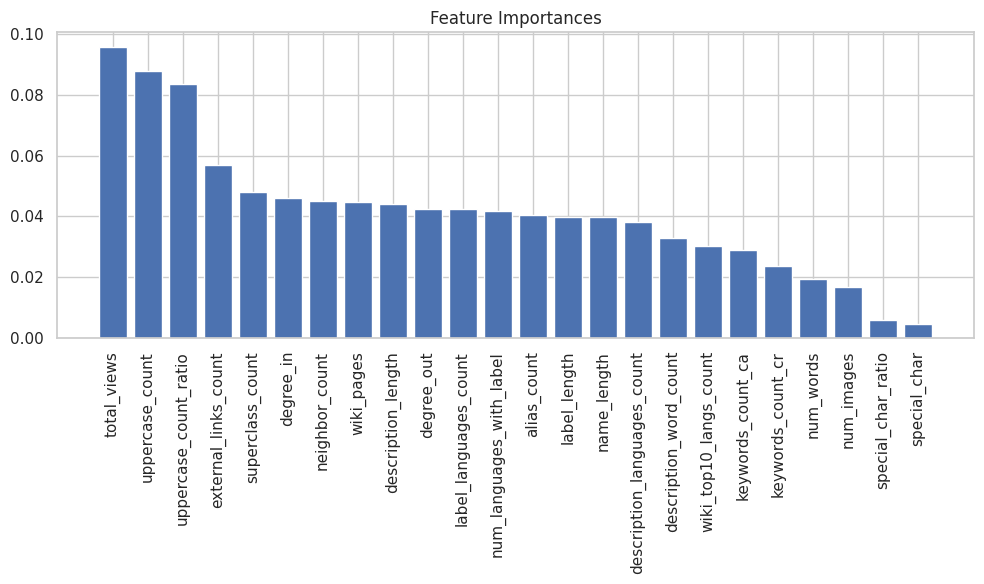

In [53]:
model = RandomForestClassifier(
    n_estimators=150,
    max_depth=None,
    random_state=42
)
model.fit(X_train_scaled, y_train)

importances = model.feature_importances_
feat_names = X_train.columns

# Ordina e mostra
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), feat_names[indices], rotation=90)
plt.tight_layout()
plt.show()

## Model 1 SVM

In [41]:
# grid for the hyperparameters
param_grid = {
    'C': [12, 15, 18],
    'gamma': [ 0.01, 0.02, 0.03],
    'kernel': ['rbf']
}

# Initialization of the classifier
svc = SVC(class_weight=class_weight,
          probability=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#  GridSearch config
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation  score:", grid_search.best_score_)

best_model_1 = grid_search.best_estimator_
joblib.dump(best_model_1, best_model_svm_path)

y_pred_1 = best_model_1.predict(X_dev_scaled)
y_proba_1 = best_model_1.predict_proba(X_dev_scaled)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found: {'C': 12, 'gamma': 0.03, 'kernel': 'rbf'}
Best cross-validation  score: 0.6968505195843325


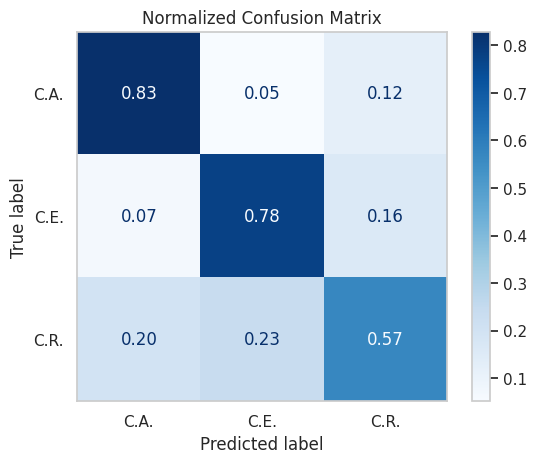

Accuracy:  0.723
Precision: 0.724
Recall:    0.723
F1 Score:  0.720


In [42]:
# Confusion matrix
cm = confusion_matrix(y_dev, y_pred_1, normalize='true')
classes = ['C.A.', 'C.E.', 'C.R.']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)
ax.grid(False)
plt.title("Normalized Confusion Matrix")
plt.show()


# metrics for evaluation
accuracy = accuracy_score(y_dev, y_pred_1)
precision = precision_score(y_dev, y_pred_1, average='weighted', zero_division=0)
recall = recall_score(y_dev, y_pred_1, average='weighted', zero_division=0)
f1 = f1_score(y_dev, y_pred_1, average='weighted', zero_division=0)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

## Model 2 Random Forest

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found: {'max_depth': None, 'n_estimators': 150}
Best cross-validation score: 0.7152460431654677


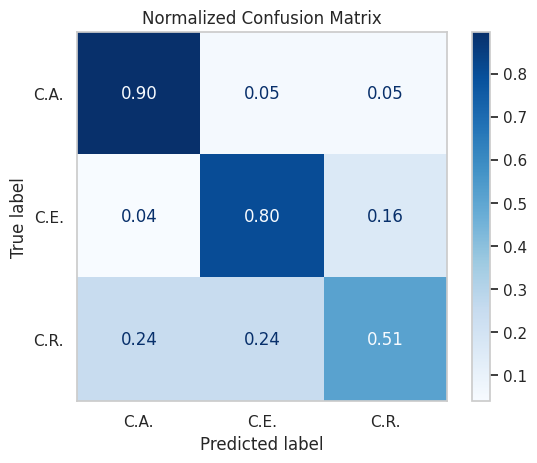

Accuracy:  0.737
Precision: 0.740
Recall:    0.737
F1 Score:  0.727


In [43]:
# Grid of the parameters
param_grid = {
    'n_estimators': [120, 150, 180],
    'max_depth': [None, 20, 30],
}

# Initialization of the classifier
rf_clf = RandomForestClassifier(
    class_weight=class_weight,
    n_jobs=-1,
    random_state=42
    )

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# Configuration of the GridSearch
grid_search = GridSearchCV(
    estimator= rf_clf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)


# GridSearch on normalized data
grid_search.fit(X_train_scaled, y_train)
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Using the best model on the dev set
best_model_2 = grid_search.best_estimator_
y_pred_2 = best_model_2.predict(X_dev_scaled)
joblib.dump(best_model_2, best_model_rf_path)

# Confusion matrix
cm = confusion_matrix(y_dev, y_pred_2, normalize='true')
classes = ['C.A.', 'C.E.', 'C.R.']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)
ax.grid(False)

plt.title("Normalized Confusion Matrix")
plt.show()

# evaluation metrics
accuracy = accuracy_score(y_dev, y_pred_2)
precision = precision_score(y_dev, y_pred_2, average='weighted', zero_division=0)
recall = recall_score(y_dev, y_pred_2, average='weighted', zero_division=0)
f1 = f1_score(y_dev, y_pred_2, average='weighted', zero_division=0)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

y_proba_2 = best_model_2.predict_proba(X_dev_scaled)

## Model 3 XGB

In [44]:
# Parameters to optimize
param_grid = {
    'n_estimators': [10, 20, 30, 40],
    'max_depth': [4, 5, 6, 7],
}

# Initialization of XGBClassifier
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_jobs=-1,
    eval_metric='mlogloss',
    random_state=42
)


# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

# Best parameters found
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Evaluataion on dev set
best_model_3 = grid_search.best_estimator_
joblib.dump(best_model_3, best_model_xgb_path)

y_pred_3 = best_model_3.predict(X_dev_scaled)
y_proba_3 = best_model_3.predict_proba(X_dev_scaled)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters found: {'max_depth': 5, 'n_estimators': 40}
Best cross-validation score:  0.7142879616306954


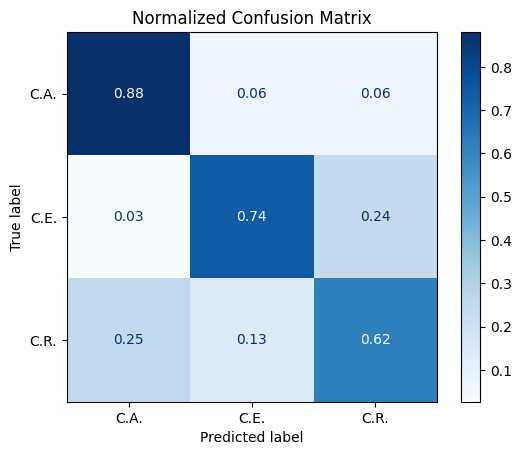

Accuracy:  0.750
Precision: 0.747
Recall:    0.750
F1 Score:  0.746


In [16]:
# Confusion matrix
cm = confusion_matrix(y_dev, y_pred_3, normalize='true')
classes = ['C.A.', 'C.E.', 'C.R.']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)
ax.grid(False)

plt.title("Normalized Confusion Matrix")
plt.show()

# Metrics evaluation
accuracy = accuracy_score(y_dev, y_pred_3)
precision = precision_score(y_dev, y_pred_3, average='weighted', zero_division=0)
recall = recall_score(y_dev, y_pred_3, average='weighted', zero_division=0)
f1 = f1_score(y_dev, y_pred_3, average='weighted', zero_division=0)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

## Cascading

In [45]:
def cascading_predict(threshold, model1, model2, model3, X_scaled):
  y_proba_1 = model1.predict_proba(X_scaled)
  y_proba_2 = model2.predict_proba(X_scaled)
  y_proba_3 = model3.predict_proba(X_scaled)

  # Max predict_proba for each model
  max_proba_1 = np.max(y_proba_1, axis=1)
  max_proba_2 = np.max(y_proba_2, axis=1)
  max_proba_3 = np.max(y_proba_3, axis=1)

  # Prediction of each model
  pred_1 = np.argmax(y_proba_1, axis=1)
  pred_2 = np.argmax(y_proba_2, axis=1)
  pred_3 = np.argmax(y_proba_3, axis=1)

  # Cascading:
  y_pred_cascade = np.where(max_proba_1 >= threshold, pred_1,
                            np.where(max_proba_2 >= threshold, pred_2,
                                    pred_3))
  return y_pred_cascade

In [46]:
# LOAD the model
best_model_svm = joblib.load(best_model_svm_path)
best_model_rf = joblib.load(best_model_rf_path)
best_model_xgb = joblib.load(best_model_xgb_path)

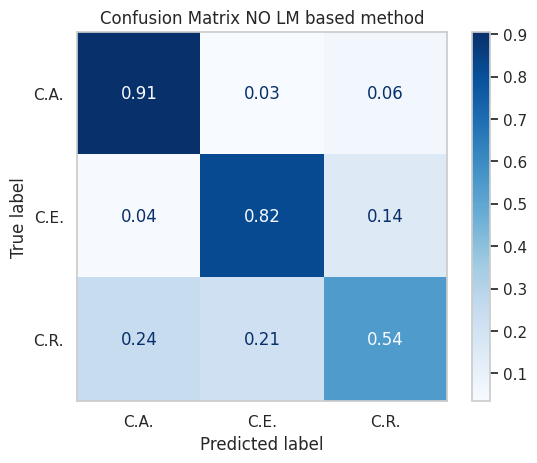

Accuracy:  0.753
Precision: 0.755
Recall:    0.753
F1 Score:  0.745
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       117
           1       0.70      0.82      0.75        76
           2       0.76      0.54      0.63       107

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.74       300
weighted avg       0.75      0.75      0.74       300



In [50]:
threshold = 0.65

model_in_order = [
    best_model_rf,
    best_model_svm,
    best_model_xgb]

y_pred_cascade = cascading_predict(threshold = threshold,
                                   model1 = model_in_order[0],   # less performant
                                   model2 = model_in_order[1],
                                   model3 = model_in_order[2],   # most performant
                                   X_scaled = X_dev_scaled
                                   )

# Confusion matrix
cm = confusion_matrix(y_dev, y_pred_cascade, normalize='true')
classes = ['C.A.', 'C.E.', 'C.R.']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)
ax.grid(False)

plt.title("Confusion Matrix NO LM based method")
plt.show()

# evauation metrics
accuracy = accuracy_score(y_dev, y_pred_cascade)
precision = precision_score(y_dev, y_pred_cascade, average='weighted', zero_division=0)
recall = recall_score(y_dev, y_pred_cascade, average='weighted', zero_division=0)
f1 = f1_score(y_dev, y_pred_cascade, average='weighted', zero_division=0)
print(f"Accuracy:  {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1 Score:  {f1:.3f}")

report = classification_report(y_dev, y_pred_cascade)
print(report)

# Test set

## Pipeline on the test set

In [48]:
df_test = pd.read_csv(original_test_dataset_path)
df_test.head()

,item,name,description,type,category,subcategory
0,http://www.wikidata.org/entity/Q2427430,Northeast Flag Replacement,Zhang Xueliang's announcement on 29 December 1...,concept,History,historical event
1,http://www.wikidata.org/entity/Q125482,imam,Islamic leadership position,concept,philosophy and religion,religious leader
2,http://www.wikidata.org/entity/Q15789,FC Bayern Munich,"association football club in Munich, Germany",named entity,sports,sports club
3,http://www.wikidata.org/entity/Q582496,Fome Zero,program intended to eradicate hunger and extre...,named entity,politics,government agency
4,http://www.wikidata.org/entity/Q572811,Anthony Award,awards given at Bouchercon for mystery literature,named entity,Literature,literary award


In [ ]:
print("Saving the first 1000 characters of the Wikipedia description for each item...")
save_first_1000_chars(dataset = df_test,
                      output_file = test_description_path)

Saving the first 1000 characters of the Wikipedia description for each item...
[1] Processing: http://www.wikidata.org/entity/Q2427430
Entity ID: Q2427430
[2] Processing: http://www.wikidata.org/entity/Q125482
Entity ID: Q125482
[3] Processing: http://www.wikidata.org/entity/Q15789
Entity ID: Q15789
[4] Processing: http://www.wikidata.org/entity/Q582496
Entity ID: Q582496
[5] Processing: http://www.wikidata.org/entity/Q572811
Entity ID: Q572811
[6] Processing: http://www.wikidata.org/entity/Q1866547
Entity ID: Q1866547
[7] Processing: http://www.wikidata.org/entity/Q19081
Entity ID: Q19081
[8] Processing: http://www.wikidata.org/entity/Q474090
Entity ID: Q474090
[9] Processing: http://www.wikidata.org/entity/Q1266300
Entity ID: Q1266300
[10] Processing: http://www.wikidata.org/entity/Q193654
Entity ID: Q193654
[11] Processing: http://www.wikidata.org/entity/Q372
Entity ID: Q372
[12] Processing: http://www.wikidata.org/entity/Q820887
Entity ID: Q820887
[13] Processing: http://www.wikida

In [ ]:
print("Augmenting the dataset...")
df_test = pd.read_csv(original_test_dataset_path)
df_test_augmented = pipeline_augmentation_dataset(dataset = df_test,
                                                  wiki_description_file_path = test_description_path,
                                                  keywords_cr = keywords_cr,
                                                  keywords_ca = keywords_ca,
                                                  wiki_file_path = test_wiki_file_path)

df_test_augmented.to_csv(augmented_test_dataset_path, index=False)

Augmenting the dataset...
add_name_length
add_count_num_of_words
add_description_length
add_description_word_count
add_wikipages_language_info


Processing Wikidata entities: 100%|██████████| 300/300 [01:11<00:00,  4.19it/s]


add_special_chars_count
add_uppercase_number
add_keywords_count_cr
add_keywords_count_ca
add_num_images


100%|██████████| 300/300 [01:05<00:00,  4.57it/s]


add_alias_count_to_df


100%|██████████| 300/300 [01:09<00:00,  4.35it/s]


add_external_link_count


100%|██████████| 300/300 [01:55<00:00,  2.60it/s]


add_language_count_from_labels


Processing label/description languages: 100%|██████████| 300/300 [01:06<00:00,  4.51it/s]


dataset_with_wikipedia_views
Found 300 unique Wikidata IDs

Saved view stats to '/content/drive/MyDrive/the_tokenizers_shared_folder/dataset/test_wiki_file_path.csv'
augment_with_wikidata_features


Extracting features from Wikidata:  19%|█▉        | 57/300 [00:54<03:13,  1.26it/s]

SPARQL error: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'SPARQL-QUERY: queryStr=\n        SELECT (COUNT(?outProp) AS ?out) (COUNT(?inProp) AS ?inn)\n        WHERE {\n          { wd:Q1650915 ?outProp ?o . FILTER(STRSTARTS(STR(?o), "http://www.wikidata.org/entity/Q")) }\n          UNION\n          { ?s ?inProp wd:Q1650915 . FILTER(STRSTARTS(STR(?s), "http://www.wikidata.org/entity/Q")) }\n        }\n        \njava.util.concurrent.TimeoutException\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:205)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doGet(QueryServlet.java:290)\n\tat com.bigdata.rdf.sail.webapp.RESTServlet.doGet(RESTServlet.java:240)\n\tat com.bigdata.rdf.sail.webapp.MultiTenancyServlet.doGet(MultiTenancyServlet.java:273)\n\tat javax.servlet.http.HttpServl

Extracting features from Wikidata:  19%|█▉        | 58/300 [02:56<2:29:03, 36.96s/it]

SPARQL error: EndPointInternalError: The endpoint returned the HTTP status code 500. 

Response:
b'SPARQL-QUERY: queryStr=\n        SELECT (COUNT(DISTINCT ?neighbor) AS ?neighborCount)\n        WHERE {\n          { wd:Q1650915 ?p1 ?neighbor FILTER(STRSTARTS(STR(?neighbor), "http://www.wikidata.org/entity/Q")) }\n          UNION\n          { ?neighbor ?p2 wd:Q1650915 FILTER(STRSTARTS(STR(?neighbor), "http://www.wikidata.org/entity/Q")) }\n        }\n        \njava.util.concurrent.TimeoutException\n\tat java.util.concurrent.FutureTask.get(FutureTask.java:205)\n\tat com.bigdata.rdf.sail.webapp.BigdataServlet.submitApiTask(BigdataServlet.java:292)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doSparqlQuery(QueryServlet.java:678)\n\tat com.bigdata.rdf.sail.webapp.QueryServlet.doGet(QueryServlet.java:290)\n\tat com.bigdata.rdf.sail.webapp.RESTServlet.doGet(RESTServlet.java:240)\n\tat com.bigdata.rdf.sail.webapp.MultiTenancyServlet.doGet(MultiTenancyServlet.java:273)\n\tat javax.servlet.http

Extracting features from Wikidata: 100%|██████████| 300/300 [06:55<00:00,  1.38s/it]

Merging extracted features with original dataset...
[SUCCESS] Merge completed successfully.


In [ ]:
df_test_augmented = union_file_description_dataset(augmented_test_dataset_path,test_description_path)

Union Completed


In [ ]:
df_test_augmented.head()

,item,name,description,type,category,subcategory,name_length,num_words,description_length,description_word_count,...,wikidata_id,total_views,qid,degree_out,degree_in,label_length,num_languages_with_label,superclass_count,neighbor_count,text
0,http://www.wikidata.org/entity/Q2427430,Northeast Flag Replacement,Zhang Xueliang's announcement on 29 December 1...,concept,History,historical event,26,3,203,31,...,Q2427430,3857.0,Q2427430,3,3,26,22,1,6,The Northeast Flag Replacement (traditional Ch...
1,http://www.wikidata.org/entity/Q125482,imam,Islamic leadership position,concept,philosophy and religion,religious leader,4,1,27,3,...,Q125482,68333.0,Q125482,15,784,4,124,23,779,"Imam (; Arabic: إمام, imām; pl.: أئمة, a'immah..."
2,http://www.wikidata.org/entity/Q15789,FC Bayern Munich,"association football club in Munich, Germany",named entity,sports,sports club,16,3,44,6,...,Q15789,532315.0,Q15789,36,3942,16,124,1,2864,"Fußball-Club Bayern München e. V. (FCB, German..."
3,http://www.wikidata.org/entity/Q582496,Fome Zero,program intended to eradicate hunger and extre...,named entity,politics,government agency,9,2,66,10,...,Q582496,1378.0,Q582496,2,0,9,13,1,2,Fome Zero (Portuguese pronunciation: [ˈfomi ˈz...
4,http://www.wikidata.org/entity/Q572811,Anthony Award,awards given at Bouchercon for mystery literature,named entity,Literature,literary award,13,2,49,7,...,Q572811,1955.0,Q572811,12,102,13,24,11,104,The Anthony Awards are literary awards for mys...


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   item                         300 non-null    object 
 1   name                         300 non-null    object 
 2   description                  300 non-null    object 
 3   type                         300 non-null    object 
 4   category                     300 non-null    object 
 5   subcategory                  300 non-null    object 
 6   name_length                  300 non-null    int64  
 7   num_words                    300 non-null    int64  
 8   description_length           300 non-null    int64  
 9   description_word_count       300 non-null    int64  
 10  wiki_pages                   300 non-null    int64  
 11  wiki_langs                   300 non-null    object 
 12  wiki_top10_langs_count       300 non-null    int64  
 13  special_char        

In [ ]:
print(df_test_augmented.isnull().values.any())
df_test_augmented.info()

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   item                         300 non-null    object 
 1   name                         300 non-null    object 
 2   description                  300 non-null    object 
 3   type                         300 non-null    object 
 4   category                     300 non-null    object 
 5   subcategory                  300 non-null    object 
 6   name_length                  300 non-null    int64  
 7   num_words                    300 non-null    int64  
 8   description_length           300 non-null    int64  
 9   description_word_count       300 non-null    int64  
 10  wiki_pages                   300 non-null    int64  
 11  wiki_langs                   300 non-null    object 
 12  wiki_top10_langs_count       300 non-null    int64  
 13  special_char  

## Inference on test set

In [49]:
df_test_augmented = pd.read_csv(augmented_test_dataset_path)


X_test = df_test_augmented[numeric_features]
X_test_scaled = scaler.transform(X_test)

y_test_pred_cascading = cascading_predict(threshold = threshold,
                                   model1 = model_in_order[0],   # less performant
                                   model2 = model_in_order[1],
                                   model3 = model_in_order[2],   # most performant
                                   X_scaled = X_test_scaled
                                   )

inference_file_path = "/content/drive/MyDrive/the_tokenizers_shared_folder/The_Tokenizers_output_no_LLM.csv"
df_to_submit = df_test_augmented[['item', 'name']].copy()
inverse_mapping = {v: k for k, v in mapping.items()}
y_pred_cascading_labels = [inverse_mapping[i] for i in y_test_pred_cascading]
df_to_submit['label'] = y_pred_cascading_labels
df_to_submit.to_csv(inference_file_path, index=False)

In [52]:
df_to_submit

,item,name,label
0,http://www.wikidata.org/entity/Q2427430,Northeast Flag Replacement,cultural exclusive
1,http://www.wikidata.org/entity/Q125482,imam,cultural agnostic
2,http://www.wikidata.org/entity/Q15789,FC Bayern Munich,cultural representative
3,http://www.wikidata.org/entity/Q582496,Fome Zero,cultural exclusive
4,http://www.wikidata.org/entity/Q572811,Anthony Award,cultural agnostic
...,...,...,...
295,http://www.wikidata.org/entity/Q4878968,bed skirt,cultural agnostic
296,http://www.wikidata.org/entity/Q1361932,family film,cultural agnostic
297,http://www.wikidata.org/entity/Q639669,musician,cultural agnostic
298,http://www.wikidata.org/entity/Q616077,VJing,cultural agnostic
